In [1]:
!pip3 install lightgbm

In [2]:
!pip3 install xgboost

In [50]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import skew, skewtest, pearsonr, spearmanr, t, ttest_ind, normaltest, norm
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import mutual_info_classif
import itertools
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import auc, roc_curve, roc_auc_score
from collections import Counter

## Import Data

In [4]:
train = pd.read_csv("application_train.csv")
test = pd.read_csv("application_test.csv")
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
train.isna().sum()/len(train)

SK_ID_CURR                    0.000000
TARGET                        0.000000
NAME_CONTRACT_TYPE            0.000000
CODE_GENDER                   0.000000
FLAG_OWN_CAR                  0.000000
                                ...   
AMT_REQ_CREDIT_BUREAU_DAY     0.135016
AMT_REQ_CREDIT_BUREAU_WEEK    0.135016
AMT_REQ_CREDIT_BUREAU_MON     0.135016
AMT_REQ_CREDIT_BUREAU_QRT     0.135016
AMT_REQ_CREDIT_BUREAU_YEAR    0.135016
Length: 122, dtype: float64

In [6]:
train.shape

(307511, 122)

In [7]:
test.isna().sum()/len(test)

SK_ID_CURR                    0.000000
NAME_CONTRACT_TYPE            0.000000
CODE_GENDER                   0.000000
FLAG_OWN_CAR                  0.000000
FLAG_OWN_REALTY               0.000000
                                ...   
AMT_REQ_CREDIT_BUREAU_DAY     0.124097
AMT_REQ_CREDIT_BUREAU_WEEK    0.124097
AMT_REQ_CREDIT_BUREAU_MON     0.124097
AMT_REQ_CREDIT_BUREAU_QRT     0.124097
AMT_REQ_CREDIT_BUREAU_YEAR    0.124097
Length: 121, dtype: float64

In [8]:
test.shape

(48744, 121)

## EDA

In [9]:
train_num = train.select_dtypes('number')
train_num = train_num.dropna()
train_num = train_num.drop(['SK_ID_CURR'], axis=1)
train_num.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
71,0,0,103500.0,573628.5,24435.0,463500.0,0.009657,-15406,-892,-341.0,-4176,22.0,1,1,0,1,0,0,2.0,2,2,18,0,0,0,0,0,0,0.270766,0.707126,0.597192,0.1464,0.1291,0.9861,0.8096,0.1080,0.04,0.0345,0.3333,0.3750,0.0000,0.1194,0.0933,0.0000,0.0000,0.1492,0.1340,0.9861,0.8171,0.1090,0.0403,0.0345,0.3333,0.3750,0.0000,0.1304,0.0972,0.0000,0.0000,0.1478,0.1291,0.9861,0.8121,0.1087,0.04,0.0345,0.3333,0.3750,0.0000,0.1214,0.0949,0.0000,0.0000,0.1324,2.0,1.0,2.0,1.0,-2053.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
124,0,1,202500.0,260725.5,16789.5,198000.0,0.018850,-16282,-4375,-762.0,-1494,8.0,1,1,0,1,0,0,2.0,2,2,11,0,0,0,0,0,0,0.647045,0.746486,0.739412,0.0928,0.1000,0.9801,0.7280,0.0463,0.00,0.2069,0.1667,0.2083,0.0437,0.0756,0.0903,0.0000,0.0000,0.0945,0.1038,0.9801,0.7387,0.0467,0.0000,0.2069,0.1667,0.2083,0.0447,0.0826,0.0941,0.0000,0.0000,0.0937,0.1000,0.9801,0.7316,0.0466,0.00,0.2069,0.1667,0.2083,0.0445,0.0770,0.0919,0.0000,0.0000,0.0710,6.0,0.0,6.0,0.0,-1782.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
143,0,0,175500.0,1293502.5,35568.0,1129500.0,0.018850,-21961,365243,-8887.0,-4379,9.0,1,0,0,1,1,0,2.0,2,2,16,0,0,0,0,0,0,0.531106,0.646689,0.812823,0.0680,0.0730,0.9876,0.8300,0.0283,0.00,0.1724,0.1667,0.1250,0.0366,0.0546,0.0714,0.0039,0.0094,0.0693,0.0758,0.9876,0.8367,0.0286,0.0000,0.1724,0.1667,0.1250,0.0374,0.0597,0.0744,0.0039,0.0100,0.0687,0.0730,0.9876,0.8323,0.0285,0.00,0.1724,0.1667,0.1250,0.0372,0.0556,0.0727,0.0039,0.0096,0.0737,0.0,0.0,0.0,0.0,-396.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
152,0,0,202500.0,675000.0,53329.5,675000.0,0.031329,-11375,-2311,-180.0,-2009,4.0,1,1,0,1,0,0,2.0,2,2,13,0,0,0,0,0,0,0.674832,0.616156,0.673830,0.5845,0.4570,0.9945,0.9252,0.3468,0.60,0.2414,0.9167,0.5000,0.2847,0.4287,0.7187,0.2201,0.7729,0.5956,0.4742,0.9945,0.9281,0.3500,0.6042,0.2414,0.9167,0.5000,0.2912,0.4683,0.7488,0.2218,0.8183,0.5902,0.4570,0.9945,0.9262,0.3490,0.60,0.2414,0.9167,0.5000,0.2896,0.4361,0.7317,0.2213,0.7892,0.7334,0.0,0.0,0.0,0.0,-1792.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0

In [10]:
train_obj = train.select_dtypes('object')
train_obj.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN


In [11]:
train_num.describe()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,11351.000000,11351.000000,1.135100e+04,1.135100e+04,11351.000000,1.135100e+04,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.0,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.0,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000,11351.000000
mean,0.060347,0.579420,2.211785e+05,7.076174e+05,31689.027751,6.406565e+05,0.024095,-14483.533433,17310.202802,-4367.722847,-3002.893842,11.130209,1.0,0.946436,0.197428,0.996740,0.316007,0.125892,2.375738,1.995947,1.942648,12.209145,0.013831,0.058497,0.051802,0.035856,0.139635,0.125628,0.506990,0.553664,0.496230,0.131208,0.092614,0.982652,0.765384,0.048970,0.090746,0.155954,0.253121,0.245849,0.068858,0.106308,0.123804,0.009442,0.026553,0.126709,0.090599,0.982049,0.771866,0.046534,0.084923,0.150345,0.247746,0.241384,0.067064,0.111081,0.120898,0.008506,0.024052,0.131447,0.091753,0.982772,0.768614,0.048998,0.089522,0.155214,0.252789,0.245530,0.069674,0.107490,0.125140,0.009181,0.026101,0.121284,1.342172,0.127654,1.326932,0.08

1. TARGET



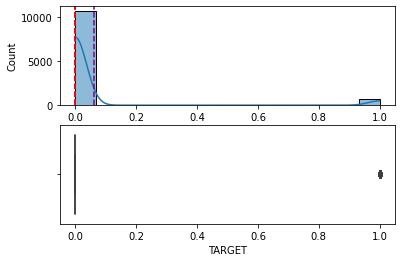

count    11351.000000
mean         0.060347
std          0.238139
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: TARGET, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

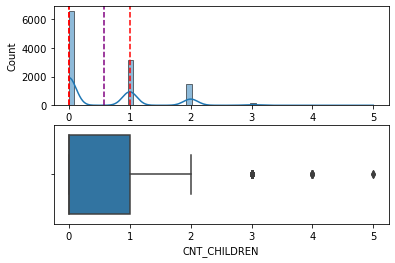

count    11351.000000
mean         0.579420
std          0.768095
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: CNT_CHILDREN, dtype: float64

lower whisker: 0
upper whisker: 2
outlier: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 5, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3]
outlier count: 151
Data skewed dengan nilai p-value 0.0 dan skew 1.11436878330423
3. AMT_INCOME_TOTAL



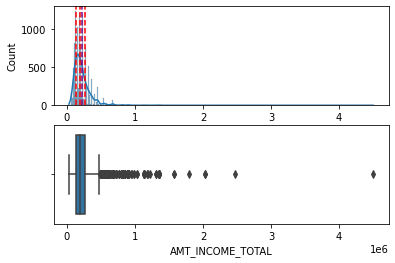

count    1.135100e+04
mean     2.211785e+05
std      1.352612e+05
min      2.925000e+04
25%      1.350000e+05
50%      1.890000e+05
75%      2.700000e+05
max      4.500000e+06
Name: AMT_INCOME_TOTAL, dtype: float64

lower whisker: 29250.0
upper whisker: 472500.0
outlier: [765000.0, 540000.0, 522000.0, 810000.0, 540000.0, 765000.0, 810000.0, 720000.0, 607500.0, 810000.0, 675000.0, 1035000.0, 630000.0, 540000.0, 540000.0, 540000.0, 1350000.0, 576000.0, 508500.0, 585000.0, 630000.0, 675000.0, 877500.0, 585000.0, 540000.0, 675000.0, 675000.0, 540000.0, 540000.0, 675000.0, 675000.0, 675000.0, 495000.0, 900000.0, 585000.0, 495000.0, 675000.0, 540000.0, 720000.0, 540000.0, 900000.0, 540000.0, 540000.0, 675000.0, 585000.0, 540000.0, 585000.0, 675000.0, 675000.0, 540000.0, 675000.0, 720000.0, 540000.0, 540000.0, 630000.0, 900000.0, 828000.0, 630000.0, 675000.0, 540000.0, 1125000.0, 540000.0, 675000.0, 810000.0, 1350000.0, 675000.0, 540000.0, 607500.0, 585000.0, 585000.0, 481500.0, 540000.0, 495

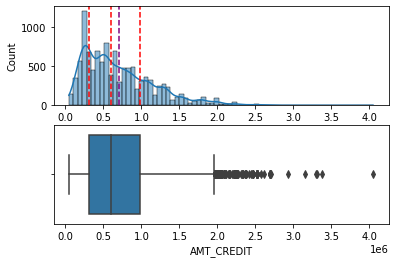

count    1.135100e+04
mean     7.076174e+05
std      4.662878e+05
min      4.500000e+04
25%      3.156660e+05
50%      5.925600e+05
75%      9.741600e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64

lower whisker: 45000.0
upper whisker: 1956289.5
outlier: [1971072.0, 1971072.0, 1965226.5, 1971072.0, 2695500.0, 2047500.0, 2013840.0, 2517300.0, 2013840.0, 1971072.0, 2250000.0, 2517300.0, 2250000.0, 2303460.0, 1971072.0, 2020347.0, 1984500.0, 2695500.0, 1971072.0, 1988667.0, 2025000.0, 2064186.0, 2215224.0, 2463840.0, 2250000.0, 2048580.0, 2059056.0, 2250000.0, 1971072.0, 1984500.0, 2250000.0, 2517300.0, 1971072.0, 2250000.0, 2341089.0, 2250000.0, 2220259.5, 2013840.0, 1971072.0, 1971072.0, 2931660.0, 2340000.0, 1994670.0, 1971072.0, 2250000.0, 2028942.0, 2085120.0, 1971072.0, 1971072.0, 2156400.0, 2151009.0, 2250000.0, 2250000.0, 2695500.0, 2250000.0, 2013840.0, 2013840.0, 2085120.0, 1971072.0, 1971072.0, 2013840.0, 1971072.0, 2033977.5, 2013840.0, 1971072.0, 2013840.0, 199873

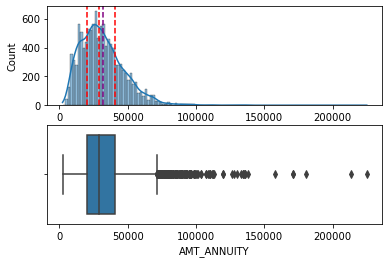

count     11351.000000
mean      31689.027751
std       16580.842224
min        2317.500000
25%       19867.500000
50%       29353.500000
75%       40459.500000
max      225000.000000
Name: AMT_ANNUITY, dtype: float64

lower whisker: 2317.5
upper whisker: 71235.0
outlier: [135936.0, 94509.0, 71590.5, 80239.5, 74254.5, 110488.5, 72076.5, 77089.5, 108805.5, 91147.5, 71590.5, 72274.5, 74416.5, 95463.0, 98338.5, 85869.0, 213291.0, 171040.5, 78367.5, 74254.5, 80149.5, 72828.0, 87957.0, 78903.0, 98811.0, 98640.0, 95800.5, 74830.5, 135724.5, 74110.5, 84937.5, 71703.0, 94509.0, 72036.0, 127989.0, 79915.5, 79947.0, 96003.0, 79065.0, 84937.5, 72715.5, 93478.5, 137844.0, 112297.5, 75127.5, 75487.5, 95332.5, 74110.5, 134604.0, 76923.0, 81895.5, 72036.0, 71518.5, 72607.5, 106947.0, 89235.0, 79492.5, 80766.0, 79708.5, 72607.5, 91219.5, 107050.5, 71649.0, 103455.0, 96214.5, 92223.0, 76626.0, 72562.5, 72693.0, 92673.0, 88839.0, 101497.5, 87696.0, 87678.0, 72207.0, 76837.5, 98379.0, 83407.5, 79708.5, 8

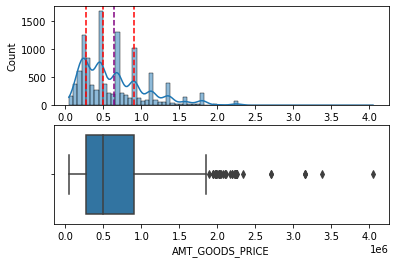

count    1.135100e+04
mean     6.406565e+05
std      4.309243e+05
min      4.500000e+04
25%      2.700000e+05
50%      4.950000e+05
75%      9.000000e+05
max      4.050000e+06
Name: AMT_GOODS_PRICE, dtype: float64

lower whisker: 45000.0
upper whisker: 1845000.0
outlier: [2250000.0, 2047500.0, 2250000.0, 2250000.0, 2250000.0, 2250000.0, 2250000.0, 1984500.0, 2250000.0, 2025000.0, 1980000.0, 2250000.0, 2250000.0, 2250000.0, 1984500.0, 2250000.0, 2250000.0, 1935000.0, 2250000.0, 2092500.0, 2250000.0, 1984500.0, 2700000.0, 2340000.0, 2250000.0, 2250000.0, 2250000.0, 2250000.0, 2250000.0, 2250000.0, 2250000.0, 2025000.0, 2250000.0, 2160000.0, 2250000.0, 2250000.0, 1984500.0, 4050000.0, 2223000.0, 2250000.0, 2092500.0, 1984500.0, 2250000.0, 2250000.0, 2250000.0, 1890000.0, 1984500.0, 2250000.0, 1935000.0, 2250000.0, 2250000.0, 2250000.0, 2250000.0, 1980000.0, 2250000.0, 2250000.0, 3150000.0, 2700000.0, 2250000.0, 2025000.0, 2250000.0, 2250000.0, 1966500.0, 2250000.0, 2025000.0, 2250000.0, 2

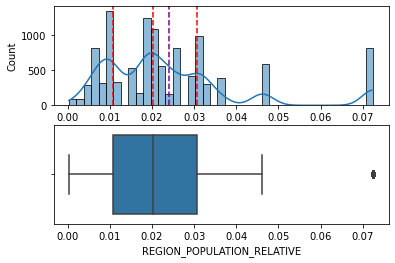

count    11351.000000
mean         0.024095
std          0.016970
min          0.000290
25%          0.010643
50%          0.020246
75%          0.030755
max          0.072508
Name: REGION_POPULATION_RELATIVE, dtype: float64

lower whisker: 0.00029
upper whisker: 0.04622
outlier: [0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508, 0.072508

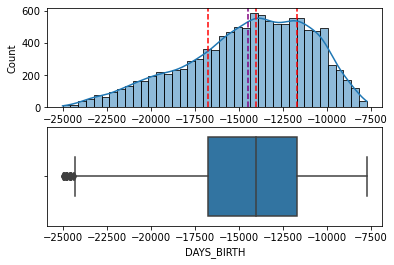

count    11351.000000
mean    -14483.533433
std       3547.769641
min     -25018.000000
25%     -16762.500000
50%     -14029.000000
75%     -11707.000000
max      -7708.000000
Name: DAYS_BIRTH, dtype: float64

lower whisker: -24336
upper whisker: -7708
outlier: [-24374, -24418, -24607, -24911, -24791, -24830, -24835, -25018, -24587, -24821, -24566, -25009, -24765, -24544, -24661, -24911, -24773, -24551, -24830, -24832, -24855]
outlier count: 21
Data skewed dengan nilai p-value 6.942351199703281e-103 dan skew -0.5256337395069207
9. DAYS_EMPLOYED



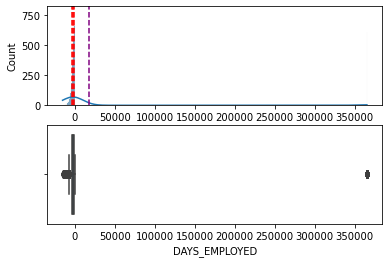

count     11351.000000
mean      17310.202802
std       82583.957313
min      -15183.000000
25%       -3010.500000
50%       -1573.000000
75%        -679.500000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

lower whisker: -6506
upper whisker: -4
outlier: [365243, -7668, -7115, 365243, -6589, 365243, 365243, -7514, 365243, -11534, 365243, 365243, -6556, -7164, 365243, 365243, -7220, -8478, -10624, 365243, 365243, 365243, 365243, 365243, 365243, 365243, -7319, -8845, 365243, -8404, -6606, -7044, 365243, -8150, -8268, -9938, 365243, -6523, -12241, 365243, 365243, 365243, -8234, 365243, -8657, -7562, -9622, 365243, 365243, -7048, -11696, -6709, 365243, 365243, 365243, 365243, 365243, 365243, 365243, 365243, 365243, -8412, 365243, -9673, 365243, -8727, -8495, -6959, -9363, -7047, -12886, 365243, 365243, -12659, 365243, 365243, 365243, 365243, -6716, 365243, -7916, 365243, 365243, 365243, 365243, -6644, -6943, 365243, 365243, 365243, 365243, -8385, 365243, -9372, 365243, -10096

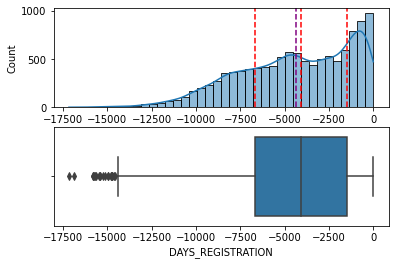

count    11351.000000
mean     -4367.722847
std       3174.935731
min     -17176.000000
25%      -6694.000000
50%      -4069.000000
75%      -1489.500000
max          0.000000
Name: DAYS_REGISTRATION, dtype: float64

lower whisker: -14426.0
upper whisker: 0.0
outlier: [-15236.0, -14795.0, -14990.0, -15134.0, -15818.0, -15497.0, -14647.0, -15633.0, -16906.0, -14721.0, -14769.0, -14791.0, -15719.0, -17176.0, -15429.0, -15763.0, -15811.0, -14996.0, -15412.0, -14584.0, -14725.0]
outlier count: 21
Data skewed dengan nilai p-value 4.987681405860108e-107 dan skew -0.5376284228053546
11. DAYS_ID_PUBLISH



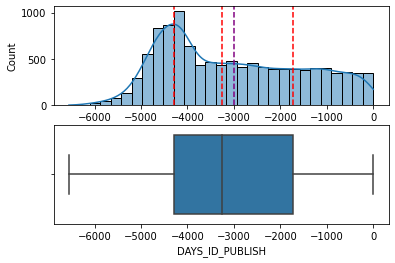

count    11351.000000
mean     -3002.893842
std       1510.127632
min      -6551.000000
25%      -4293.000000
50%      -3254.000000
75%      -1736.000000
max         -1.000000
Name: DAYS_ID_PUBLISH, dtype: float64

lower whisker: -6551
upper whisker: -1
outlier: []
outlier count: 0
Data skewed dengan nilai p-value 8.106909954099543e-45 dan skew 0.33118033659738105
12. OWN_CAR_AGE



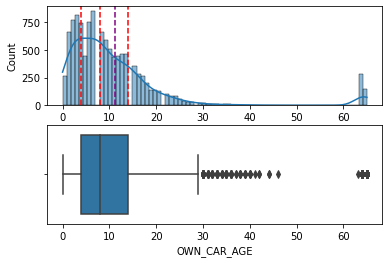

count    11351.000000
mean        11.130209
std         12.330491
min          0.000000
25%          4.000000
50%          8.000000
75%         14.000000
max         65.000000
Name: OWN_CAR_AGE, dtype: float64

lower whisker: 0.0
upper whisker: 29.0
outlier: [64.0, 64.0, 64.0, 64.0, 64.0, 65.0, 65.0, 65.0, 64.0, 64.0, 64.0, 64.0, 32.0, 32.0, 65.0, 65.0, 65.0, 64.0, 64.0, 64.0, 65.0, 64.0, 65.0, 65.0, 64.0, 64.0, 37.0, 64.0, 64.0, 64.0, 65.0, 33.0, 64.0, 64.0, 65.0, 65.0, 65.0, 39.0, 64.0, 64.0, 64.0, 30.0, 36.0, 64.0, 64.0, 64.0, 64.0, 64.0, 65.0, 38.0, 64.0, 65.0, 65.0, 65.0, 33.0, 65.0, 64.0, 65.0, 64.0, 30.0, 64.0, 65.0, 64.0, 30.0, 64.0, 64.0, 35.0, 64.0, 64.0, 65.0, 65.0, 64.0, 32.0, 64.0, 37.0, 65.0, 31.0, 33.0, 65.0, 64.0, 64.0, 64.0, 65.0, 65.0, 64.0, 30.0, 65.0, 64.0, 64.0, 64.0, 64.0, 64.0, 65.0, 64.0, 32.0, 65.0, 64.0, 64.0, 64.0, 64.0, 64.0, 41.0, 38.0, 64.0, 65.0, 65.0, 35.0, 64.0, 64.0, 64.0, 64.0, 35.0, 64.0, 64.0, 31.0, 65.0, 65.0, 65.0, 64.0, 64.0, 64.0, 33.0, 65.0, 64

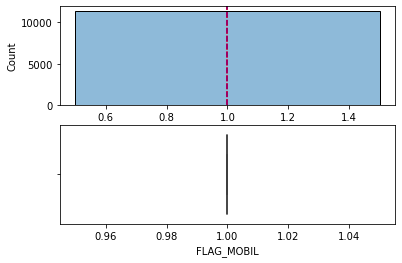

count    11351.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: FLAG_MOBIL, dtype: float64

lower whisker: 1
upper whisker: 1
outlier: []
outlier count: 0
Data tidak skewed
14. FLAG_EMP_PHONE



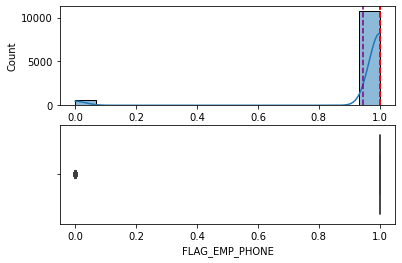

count    11351.000000
mean         0.946436
std          0.225164
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: FLAG_EMP_PHONE, dtype: float64

lower whisker: 1
upper whisker: 1
outlier: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

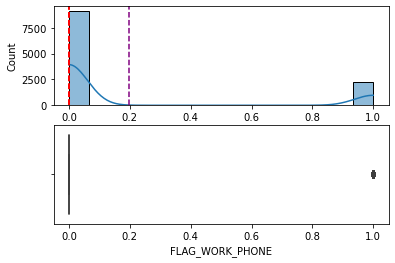

count    11351.000000
mean         0.197428
std          0.398075
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG_WORK_PHONE, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

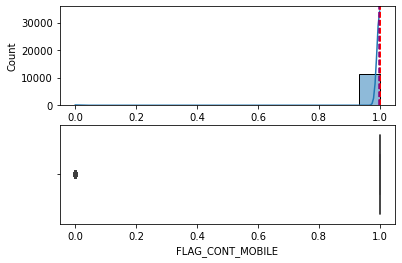

count    11351.000000
mean         0.996740
std          0.057003
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: FLAG_CONT_MOBILE, dtype: float64

lower whisker: 1
upper whisker: 1
outlier: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
outlier count: 37
Data skewed dengan nilai p-value 0.0 dan skew -17.429488060995556
17. FLAG_PHONE



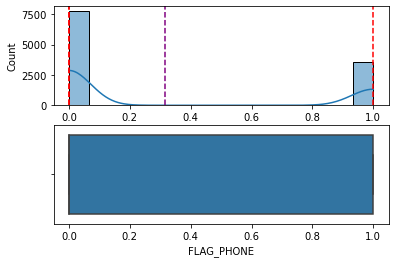

count    11351.000000
mean         0.316007
std          0.464936
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: FLAG_PHONE, dtype: float64

lower whisker: 0
upper whisker: 1
outlier: []
outlier count: 0
Data skewed dengan nilai p-value 5.269308328596221e-205 dan skew 0.7915093027501869
18. FLAG_EMAIL



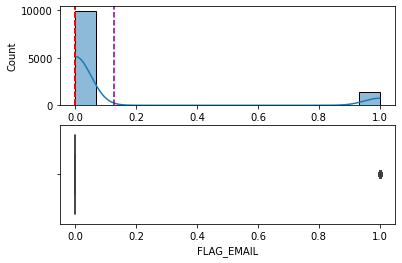

count    11351.000000
mean         0.125892
std          0.331742
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG_EMAIL, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

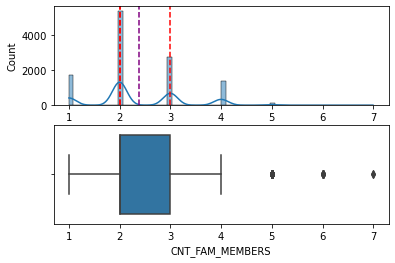

count    11351.000000
mean         2.375738
std          0.927622
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: CNT_FAM_MEMBERS, dtype: float64

lower whisker: 1.0
upper whisker: 4.0
outlier: [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 7.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 5.0, 5.0, 5.0, 5.0, 6.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 5.0, 5.0, 7.0, 6.0, 5.0, 5.0, 6.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 5.0]
outlier

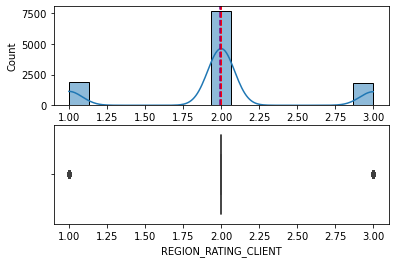

count    11351.000000
mean         1.995947
std          0.570942
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: REGION_RATING_CLIENT, dtype: float64

lower whisker: 2
upper whisker: 2
outlier: [3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1

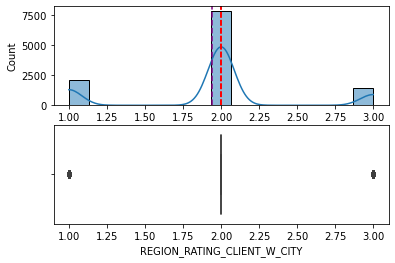

count    11351.000000
mean         1.942648
std          0.554331
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: REGION_RATING_CLIENT_W_CITY, dtype: float64

lower whisker: 2
upper whisker: 2
outlier: [3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 

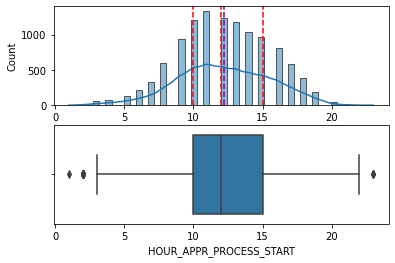

count    11351.000000
mean        12.209145
std          3.352657
min          1.000000
25%         10.000000
50%         12.000000
75%         15.000000
max         23.000000
Name: HOUR_APPR_PROCESS_START, dtype: float64

lower whisker: 3
upper whisker: 22
outlier: [2, 23, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 23, 23, 2, 2, 2]
outlier count: 21
Data skewed dengan nilai p-value 0.0002806880545092224 dan skew -0.08360502027622951
23. REG_REGION_NOT_LIVE_REGION



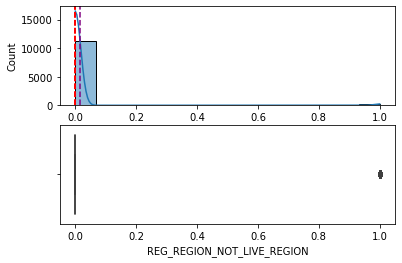

count    11351.000000
mean         0.013831
std          0.116796
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: REG_REGION_NOT_LIVE_REGION, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
outlier count: 157
Data skewed dengan nilai p-value 0.0 dan skew 8.32546625889861
24. REG_REGION_NOT_WORK_REGION



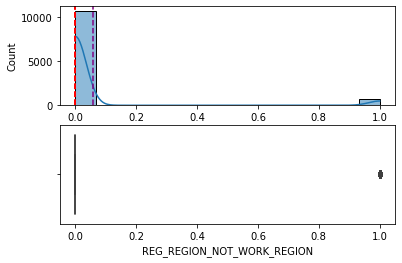

count    11351.000000
mean         0.058497
std          0.234691
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: REG_REGION_NOT_WORK_REGION, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

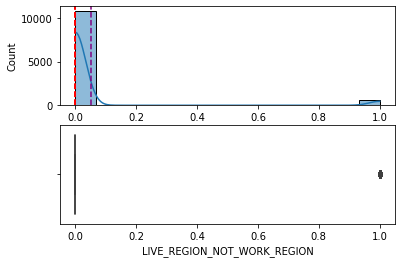

count    11351.000000
mean         0.051802
std          0.221636
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: LIVE_REGION_NOT_WORK_REGION, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

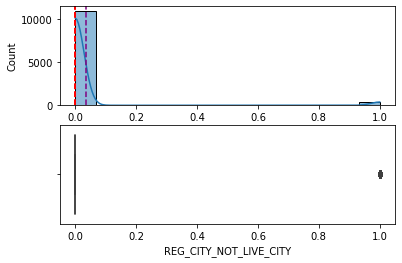

count    11351.000000
mean         0.035856
std          0.185939
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: REG_CITY_NOT_LIVE_CITY, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

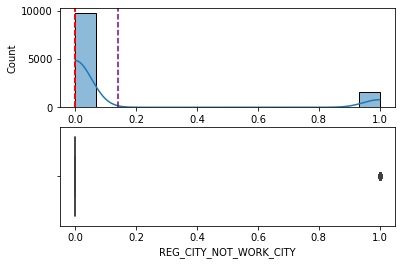

count    11351.000000
mean         0.139635
std          0.346623
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: REG_CITY_NOT_WORK_CITY, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

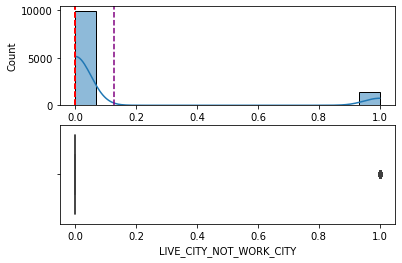

count    11351.000000
mean         0.125628
std          0.331444
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: LIVE_CITY_NOT_WORK_CITY, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

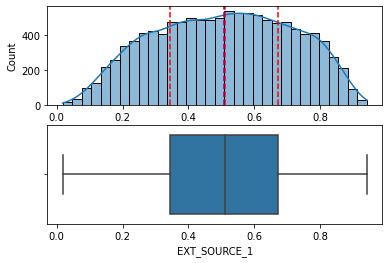

count    11351.000000
mean         0.506990
std          0.205929
min          0.017756
25%          0.343575
50%          0.512040
75%          0.672391
max          0.941619
Name: EXT_SOURCE_1, dtype: float64

lower whisker: 0.0177556587547661
upper whisker: 0.9416191102499678
outlier: []
outlier count: 0
Data skewed dengan nilai p-value 0.002513045578685235 dan skew -0.06951126735565957
30. EXT_SOURCE_2



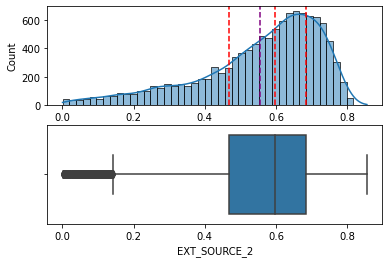

count    11351.000000
mean         0.553664
std          0.172412
min          0.000405
25%          0.466796
50%          0.596681
75%          0.683355
max          0.855000
Name: EXT_SOURCE_2, dtype: float64

lower whisker: 0.1421573839975535
upper whisker: 0.8549996664047012
outlier: [0.074082159827834, 0.0425485169166585, 0.034742420843593, 0.0721278241686903, 0.0756359267794488, 0.001767095677839, 0.0612257574664644, 0.096291781972542, 0.1287531584416871, 0.0074371374218259, 0.1244328499001608, 0.1236416586215339, 0.0889549174328073, 0.0198486145065162, 0.0817807730637229, 0.1270870197911946, 0.0377894344552376, 0.0397038688459531, 0.0046353272365434, 0.0937012819708266, 0.0522019502491632, 0.0991431671238047, 0.0790895780296463, 0.004154063072837, 0.0714734683993102, 0.0389209671182599, 0.0819253937984789, 0.1116907580045099, 0.0415192121899917, 0.0281885834876674, 0.1362210671821071, 0.1078405285278744, 0.0297153527325488, 0.0922829540027026, 0.0575583168801907, 0.1300019633610

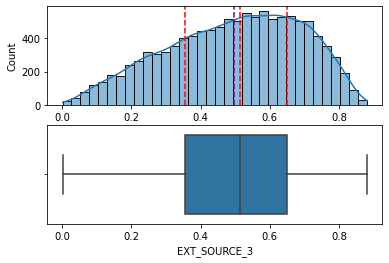

count    11351.000000
mean         0.496230
std          0.192920
min          0.000527
25%          0.355639
50%          0.513694
75%          0.651260
max          0.881027
Name: EXT_SOURCE_3, dtype: float64

lower whisker: 0.0005272652387098
upper whisker: 0.881026574983999
outlier: []
outlier count: 0
Data skewed dengan nilai p-value 3.756737490842764e-39 dan skew -0.30758763328667615
32. APARTMENTS_AVG



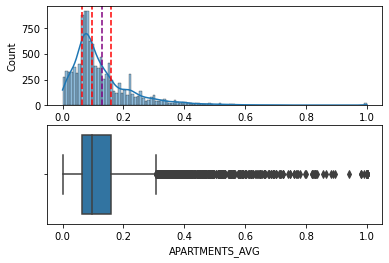

count    11351.000000
mean         0.131208
std          0.115172
min          0.000000
25%          0.062900
50%          0.096900
75%          0.160800
max          1.000000
Name: APARTMENTS_AVG, dtype: float64

lower whisker: 0.0
upper whisker: 0.3072
outlier: [0.5845, 0.3093, 0.4072, 0.4572, 0.4402, 0.5474, 0.5134, 0.3814, 0.3089, 0.3928, 0.3351, 0.3392, 0.333, 0.3897, 0.3227, 0.3232, 0.3144, 0.3773, 0.3165, 0.5474, 0.6021, 0.4062, 0.3457, 0.3866, 0.3299, 1.0, 0.3474, 0.3351, 0.4701, 0.5103, 0.4062, 0.3299, 0.3948, 0.4454, 0.3711, 0.3309, 0.3155, 0.5546, 0.3701, 0.3691, 0.3289, 0.3113, 0.3711, 0.6619, 0.3223, 0.3696, 0.3691, 0.3412, 0.7165, 0.334, 0.4918, 0.3948, 0.4897, 0.4948, 0.4753, 0.3686, 0.3753, 0.3505, 0.3423, 0.3093, 0.5196, 0.4433, 0.3722, 0.4814, 0.4794, 1.0, 0.3361, 0.4, 0.5485, 0.6907, 0.3918, 0.3172, 0.4918, 0.3134, 0.3134, 0.3581, 0.4433, 0.3612, 0.3732, 0.3144, 0.4, 0.3268, 0.3082, 0.3887, 0.4467, 0.368, 0.3711, 0.3531, 0.5113, 0.4804, 0.6186, 0.3289, 0.3227, 0.4206

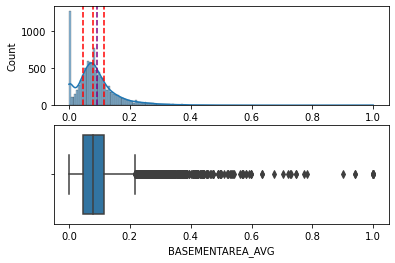

count    11351.000000
mean         0.092614
std          0.081489
min          0.000000
25%          0.047900
50%          0.079200
75%          0.116050
max          1.000000
Name: BASEMENTAREA_AVG, dtype: float64

lower whisker: 0.0
upper whisker: 0.2182
outlier: [0.457, 0.2893, 0.2371, 0.2555, 0.4526, 0.3599, 0.3434, 0.2478, 0.5329, 0.2582, 0.3082, 0.3386, 0.4526, 0.3266, 0.2255, 0.2242, 0.3855, 0.6345, 0.3149, 0.2837, 0.2955, 0.2291, 0.262, 0.2665, 0.2347, 0.2482, 0.2583, 0.4067, 0.2638, 0.3314, 0.2381, 0.2445, 0.2321, 0.277, 0.5685, 0.2545, 0.3744, 0.2353, 0.22, 0.2195, 0.9397, 0.2466, 0.4964, 0.2302, 0.2218, 0.3184, 0.2842, 0.3818, 0.2909, 0.2618, 0.3545, 0.2693, 0.3329, 0.3267, 0.2657, 0.4636, 0.2209, 0.2519, 0.2836, 0.4748, 0.2555, 1.0, 0.388, 0.3394, 0.3018, 0.2302, 0.2188, 0.2348, 0.2697, 0.4979, 0.8998, 0.2566, 0.2404, 0.3235, 0.2241, 0.3027, 0.3331, 0.3572, 0.2911, 0.3044, 0.3874, 0.2239, 0.413, 0.4722, 0.2501, 0.396, 0.2647, 0.4204, 0.2367, 0.2446, 0.2422, 0.3387, 0.3695, 

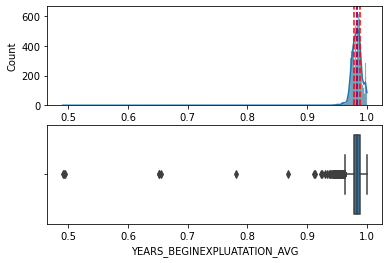

count    11351.000000
mean         0.982652
std          0.012741
min          0.490300
25%          0.977600
50%          0.983100
75%          0.987600
max          1.000000
Name: YEARS_BEGINEXPLUATATION_AVG, dtype: float64

lower whisker: 0.9627
upper whisker: 1.0
outlier: [0.9608, 0.9588, 0.9588, 0.9121, 0.9593, 0.9513, 0.9593, 0.9593, 0.9563, 0.9613, 0.9583, 0.9518, 0.9588, 0.9617, 0.9608, 0.9617, 0.9488, 0.9573, 0.9617, 0.9463, 0.9588, 0.9603, 0.9608, 0.9518, 0.9603, 0.9513, 0.9394, 0.9518, 0.9488, 0.9603, 0.9518, 0.9588, 0.9622, 0.9548, 0.9518, 0.6513, 0.4903, 0.9583, 0.9622, 0.9608, 0.9622, 0.9478, 0.9622, 0.9518, 0.9578, 0.9617, 0.9518, 0.9608, 0.9578, 0.9518, 0.9593, 0.9613, 0.9513, 0.9459, 0.9617, 0.9488, 0.9603, 0.9563, 0.6547, 0.9593, 0.6513, 0.9593, 0.9463, 0.9598, 0.9593, 0.9434, 0.9568, 0.9523, 0.9518, 0.9508, 0.9523, 0.9603, 0.9588, 0.9583, 0.9598, 0.9578, 0.9598, 0.9622, 0.9617, 0.9613, 0.9518, 0.9598, 0.9568, 0.9617, 0.9598, 0.9578, 0.9598, 0.9528, 0.9518, 0.9473, 0.

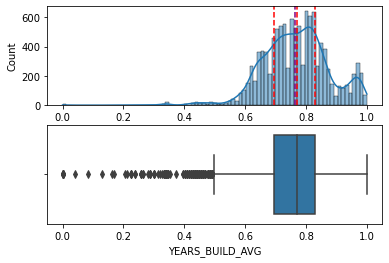

count    11351.000000
mean         0.765384
std          0.111450
min          0.000000
25%          0.694000
50%          0.768800
75%          0.830000
max          1.000000
Name: YEARS_BUILD_AVG, dtype: float64

lower whisker: 0.4968
upper whisker: 1.0
outlier: [0.4628, 0.49, 0.4356, 0.4356, 0.0, 0.4424, 0.3336, 0.4424, 0.4424, 0.4016, 0.4696, 0.4288, 0.2248, 0.49, 0.3404, 0.4356, 0.4764, 0.4628, 0.4764, 0.2996, 0.4152, 0.422, 0.4764, 0.2656, 0.4356, 0.456, 0.4628, 0.3404, 0.456, 0.3336, 0.1704, 0.3404, 0.3404, 0.456, 0.3404, 0.4356, 0.4832, 0.3744, 0.3404, 0.3404, 0.49, 0.4288, 0.4832, 0.4832, 0.4628, 0.4832, 0.286, 0.4832, 0.3404, 0.422, 0.4764, 0.3404, 0.4628, 0.422, 0.3404, 0.49, 0.49, 0.4424, 0.4696, 0.49, 0.3336, 0.2588, 0.4764, 0.2996, 0.456, 0.4016, 0.4424, 0.4424, 0.2656, 0.4492, 0.4424, 0.2248, 0.4084, 0.3472, 0.49, 0.3404, 0.3268, 0.3472, 0.456, 0.4356, 0.4288, 0.4492, 0.422, 0.49, 0.4492, 0.4832, 0.0, 0.4084, 0.4696, 0.3404, 0.4492, 0.4084, 0.4764, 0.4492, 0.422, 0.4492,

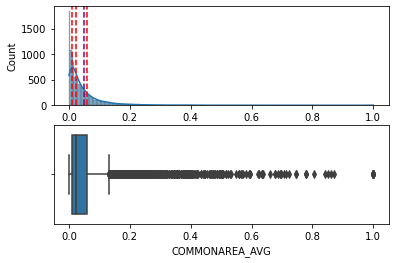

count    11351.000000
mean         0.048970
std          0.080157
min          0.000000
25%          0.008500
50%          0.024600
75%          0.058000
max          1.000000
Name: COMMONAREA_AVG, dtype: float64

lower whisker: 0.0
upper whisker: 0.1321
outlier: [0.3468, 0.4682, 0.1488, 0.1432, 0.1444, 0.3442, 0.2819, 0.1687, 0.1386, 0.2741, 0.1872, 0.3528, 0.163, 0.4782, 0.1651, 0.2055, 0.1379, 0.1432, 0.1486, 0.2034, 0.1383, 0.5589999999999999, 1.0, 0.1574, 0.2788, 0.5642, 0.1677, 0.1418, 0.3236, 0.2907, 0.2471, 0.3511, 0.2257, 0.14, 0.1402, 0.2267, 0.2895, 0.1332, 0.1584, 0.1394, 0.1324, 0.3615, 0.2174, 0.1738, 0.1695, 0.2553, 0.1709, 0.2188, 1.0, 0.259, 0.1528, 0.1572, 0.2117, 0.3547, 0.1605, 0.1814, 0.1878, 0.1564, 0.2894, 0.2812, 0.2197, 0.1414, 0.1929, 0.1759, 0.5503, 0.1451, 0.1361, 0.422, 0.2524, 0.2385, 0.1469, 0.1471, 0.1962, 0.1637, 0.3366, 0.1417, 1.0, 0.1407, 0.146, 0.2133, 0.1989, 1.0, 0.4481, 0.2885, 0.1687, 0.1658, 0.1807, 0.6334, 0.3761, 0.1809, 0.1543, 0.1703, 0.633

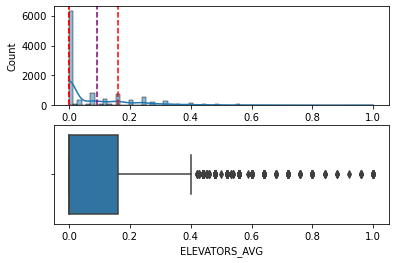

count    11351.000000
mean         0.090746
std          0.143607
min          0.000000
25%          0.000000
50%          0.000000
75%          0.160000
max          1.000000
Name: ELEVATORS_AVG, dtype: float64

lower whisker: 0.0
upper whisker: 0.4
outlier: [0.6, 0.44, 0.44, 0.6, 0.56, 0.64, 0.44, 0.64, 0.42, 0.48, 0.6, 0.44, 0.48, 0.52, 0.68, 0.64, 0.48, 0.48, 0.64, 0.72, 0.56, 0.52, 0.8, 0.72, 0.48, 0.48, 0.48, 0.64, 0.48, 0.48, 0.56, 0.48, 0.44, 0.52, 1.0, 0.48, 0.64, 0.8, 0.48, 0.48, 0.5332, 0.44, 0.64, 0.56, 1.0, 0.48, 0.44, 0.56, 1.0, 0.48, 0.48, 0.52, 0.8, 1.0, 0.56, 0.72, 0.44, 0.48, 0.56, 0.64, 0.48, 0.48, 0.88, 0.48, 0.48, 0.56, 0.56, 0.52, 0.48, 0.76, 0.64, 0.48, 0.48, 0.44, 0.4264, 0.48, 0.44, 0.44, 0.56, 0.8, 0.48, 0.48, 0.64, 0.48, 0.52, 0.76, 0.64, 0.64, 0.64, 0.44, 0.52, 0.56, 0.48, 0.44, 0.64, 0.48, 0.44, 0.48, 0.8, 0.96, 0.44, 0.44, 0.64, 0.48, 0.6, 0.56, 0.64, 0.56, 0.56, 0.48, 0.4264, 0.72, 0.48, 0.6, 0.64, 0.48, 0.72, 0.52, 0.56, 0.8, 0.48, 0.52, 0.64, 0.48, 0.56

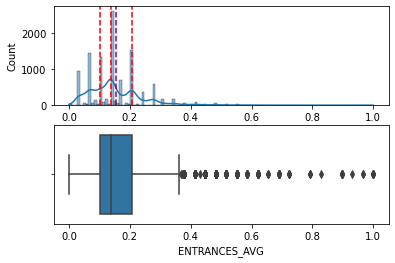

count    11351.000000
mean         0.155954
std          0.098252
min          0.000000
25%          0.103400
50%          0.137900
75%          0.206900
max          1.000000
Name: ENTRANCES_AVG, dtype: float64

lower whisker: 0.0
upper whisker: 0.3621
outlier: [0.3793, 0.6207, 0.5172, 0.3793, 0.4828, 0.8276, 0.6897, 0.5172, 0.3793, 0.4483, 1.0, 0.6897, 0.4828, 0.4138, 0.4828, 0.4828, 0.6207, 0.4138, 0.3793, 0.8966, 0.4138, 0.6207, 0.4828, 0.4138, 0.4138, 0.4483, 0.4828, 0.4138, 0.5517, 0.4138, 0.4483, 0.4828, 0.4138, 0.4138, 0.8966, 0.4828, 0.4828, 0.3793, 0.8966, 0.4483, 0.5172, 0.5172, 0.3793, 0.4138, 0.4828, 0.4138, 0.4828, 0.5517, 0.4138, 0.4138, 0.4138, 0.3793, 0.4138, 0.4138, 0.4138, 0.3793, 0.4138, 0.6552, 0.4138, 0.3793, 0.5172, 0.4483, 0.4138, 0.4138, 0.3793, 0.4828, 0.4138, 0.4828, 0.4138, 0.5517, 0.4138, 0.4483, 0.4483, 0.5172, 0.5517, 0.3793, 0.4138, 0.931, 0.4483, 0.4138, 0.3793, 0.5517, 0.4138, 0.4138, 0.4828, 0.3793, 0.6897, 0.3793, 0.4138, 0.3793, 0.4138, 0.5172, 0.51

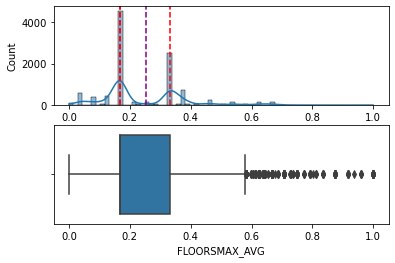

count    11351.000000
mean         0.253121
std          0.151648
min          0.000000
25%          0.166700
50%          0.166700
75%          0.333300
max          1.000000
Name: FLOORSMAX_AVG, dtype: float64

lower whisker: 0.0
upper whisker: 0.5792
outlier: [0.9167, 0.6667, 0.625, 0.6667, 0.5971, 0.625, 0.625, 0.5833, 0.625, 0.625, 0.6667, 0.625, 0.875, 0.7292, 0.6458, 0.625, 0.7917, 0.6667, 0.6667, 0.6667, 0.625, 0.6667, 0.75, 0.6146, 0.625, 0.625, 0.625, 0.625, 0.6667, 0.625, 0.625, 0.7083, 0.6667, 0.6042, 1.0, 0.6667, 0.875, 0.75, 0.7083, 0.625, 0.625, 0.6667, 0.6667, 1.0, 0.625, 0.5833, 0.625, 0.6417, 0.875, 0.7083, 0.625, 0.5971, 0.625, 0.6667, 1.0, 0.625, 0.6667, 0.6667, 0.6667, 0.8333, 0.625, 0.5833, 0.6667, 0.6667, 0.75, 0.6667, 0.6667, 0.625, 0.625, 0.6667, 0.625, 0.6667, 0.6667, 0.7083, 0.6667, 0.6667, 0.625, 0.6667, 0.5833, 0.625, 0.5833, 0.6667, 0.625, 0.625, 0.875, 0.6667, 1.0, 0.6667, 0.625, 0.625, 1.0, 0.625, 0.7083, 0.625, 0.6667, 0.625, 0.6771, 0.6667, 0.625, 0.66

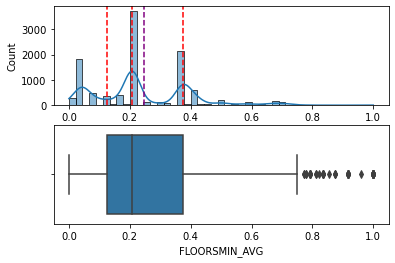

count    11351.000000
mean         0.245849
std          0.165906
min          0.000000
25%          0.125000
50%          0.208300
75%          0.375000
max          1.000000
Name: FLOORSMIN_AVG, dtype: float64

lower whisker: 0.0
upper whisker: 0.75
outlier: [0.9167, 0.8333, 0.7917, 1.0, 1.0, 1.0, 0.9167, 0.7775, 0.9167, 1.0, 0.7708, 1.0, 0.8229, 1.0, 0.9167, 1.0, 0.8333, 1.0, 1.0, 0.7917, 0.7708, 0.7775, 1.0, 0.7917, 1.0, 0.9167, 0.875, 0.8333, 1.0, 0.9167, 1.0, 0.8333, 1.0, 0.8333, 0.9583, 0.8125, 1.0, 0.8542, 1.0, 1.0, 0.7917, 0.7917, 0.9167, 0.9167, 0.9167, 0.7917, 0.875, 0.8333, 0.875, 0.9167, 0.9167, 0.7917, 1.0, 0.8125, 1.0]
outlier count: 55
Data skewed dengan nilai p-value 2.123160753626763e-238 dan skew 0.8707555699270151
41. LANDAREA_AVG



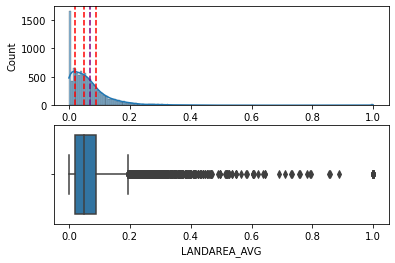

count    11351.000000
mean         0.068858
std          0.085104
min          0.000000
25%          0.019400
50%          0.049900
75%          0.089100
max          1.000000
Name: LANDAREA_AVG, dtype: float64

lower whisker: 0.0
upper whisker: 0.1936
outlier: [0.2847, 0.4101, 0.3106, 0.2761, 0.2903, 0.621, 1.0, 0.3183, 0.2668, 0.2267, 0.2524, 0.3198, 0.7604, 0.2903, 0.2056, 0.2319, 0.5113, 0.522, 0.4291, 0.3255, 0.2029, 0.2687, 0.3024, 0.2924, 0.2154, 0.2002, 0.2049, 0.2392, 0.4522, 0.2999, 0.3471, 0.2022, 0.2247, 0.2154, 0.2817, 0.7926, 1.0, 0.4239, 0.2208, 0.1999, 0.201, 0.2255, 0.2699, 0.3601, 0.2532, 0.2438, 0.3227, 0.4896, 0.2126, 0.3645, 0.2129, 0.2372, 0.1981, 0.212, 0.1968, 0.2094, 0.2664, 0.2265, 0.213, 0.3242, 0.3841, 0.2818, 0.2628, 0.3125, 0.4609, 0.2026, 0.2236, 0.3391, 0.2205, 0.3079, 0.3116, 0.1985, 0.2541, 0.4344, 0.2159, 0.2461, 0.3073, 0.4128, 0.1958, 0.2249, 0.2595, 0.2653, 0.2754, 0.3235, 0.3526, 0.2986, 0.226, 0.2178, 0.3047, 0.3645, 0.3089, 0.3031, 0.2712, 0.259

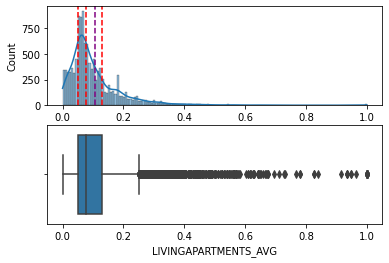

count    11351.000000
mean         0.106308
std          0.097225
min          0.000000
25%          0.050400
50%          0.076800
75%          0.130150
max          1.000000
Name: LIVINGAPARTMENTS_AVG, dtype: float64

lower whisker: 0.0
upper whisker: 0.2496
outlier: [0.4287, 0.2522, 0.3261, 0.3728, 0.3589, 0.4455, 0.4152, 0.3085, 0.3202, 0.2631, 0.2765, 0.2715, 0.3177, 0.2572, 0.2526, 0.2564, 0.3051, 0.4455, 0.4909, 0.3312, 0.2732, 0.3085, 0.269, 0.2833, 1.0, 0.2664, 0.5186, 0.4161, 0.3186, 0.3219, 0.3631, 0.3026, 0.2673, 0.2538, 0.4446, 0.3018, 0.3009, 0.2656, 0.3026, 0.5396, 0.2572, 0.3009, 0.2774, 0.564, 0.2723, 0.3984, 0.3219, 0.4035, 0.3782, 0.3597, 0.3043, 0.2849, 0.2782, 0.4236, 0.3589, 0.3018, 0.3917, 0.3883, 1.0, 0.2732, 0.3228, 0.4472, 0.5606, 0.501, 0.2533, 0.4009, 0.2538, 0.2547, 0.569, 0.3602, 0.3715, 0.3009, 0.2547, 0.3236, 0.2547, 0.3202, 0.2505, 0.3169, 0.3583, 0.2984, 0.2908, 0.306, 0.3866, 0.3908, 0.4909, 0.2681, 0.2631, 0.3425, 0.3295, 0.3043, 0.7666, 0.4035, 0.29

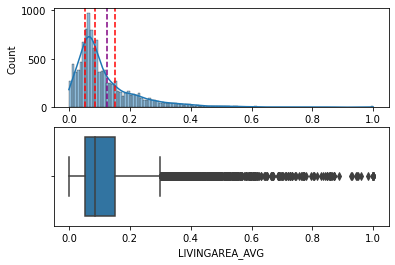

count    11351.000000
mean         0.123804
std          0.119694
min          0.000000
25%          0.054000
50%          0.085400
75%          0.152500
max          1.000000
Name: LIVINGAREA_AVG, dtype: float64

lower whisker: 0.0
upper whisker: 0.2999
outlier: [0.7187, 0.3564, 0.4133, 0.3213, 0.4587, 0.3408, 0.61, 0.5012, 0.3586, 0.309, 0.3791, 0.3613, 0.3349, 0.3394, 0.4217, 0.31, 0.3934, 0.3467, 0.3165, 0.3196, 0.3178, 0.4313, 0.4089, 0.61, 0.5634, 0.3732, 0.3771, 0.3449, 0.3487, 0.4121, 0.8722, 0.3364, 0.3922, 0.3113, 0.3383, 0.384, 0.462, 0.3897, 0.3025, 0.355, 0.306, 0.3128, 0.7042, 0.3884, 0.3736, 0.389, 0.6994, 0.3279, 0.3236, 0.3511, 0.3756, 0.3088, 0.3328, 0.3706, 0.7262, 0.3444, 0.3833, 0.3651, 0.5216, 0.5631, 0.3211, 0.5009, 0.4198, 0.3483, 0.3968, 0.4915, 0.3118, 0.3799, 0.5392, 0.5363, 0.3526, 0.3906, 0.3097, 0.5619, 0.5113, 1.0, 0.3511, 0.4073, 0.3043, 0.5902, 0.3248, 0.8474, 0.6719, 0.3935, 0.4529, 0.3141, 0.3059, 0.3186, 0.3032, 0.4369, 0.4268, 0.3934, 0.3559, 0.3166

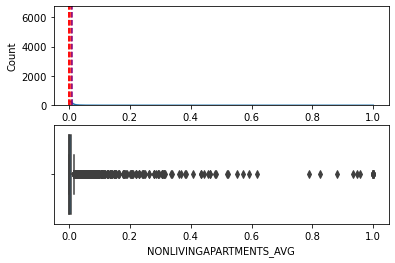

count    11351.000000
mean         0.009442
std          0.049114
min          0.000000
25%          0.000000
50%          0.000000
75%          0.006400
max          1.000000
Name: NONLIVINGAPARTMENTS_AVG, dtype: float64

lower whisker: 0.0
upper whisker: 0.0154
outlier: [0.2201, 0.027, 0.0618, 0.027, 0.0193, 0.0566, 0.0463, 0.0193, 0.0541, 0.027, 0.0193, 0.027, 0.0347, 0.0502, 0.0232, 0.0734, 0.0386, 0.0399, 0.1429, 0.0347, 0.0309, 0.027, 0.0232, 0.0309, 0.0695, 0.0232, 0.0182, 0.0232, 0.0193, 0.0309, 0.1139, 0.0347, 0.0309, 0.2085, 0.1042, 0.0579, 0.0386, 0.0724, 0.1081, 0.0193, 0.0309, 0.0193, 0.148, 0.0193, 0.0347, 0.0193, 0.1055, 0.0309, 0.0309, 0.0193, 0.0309, 0.0695, 0.5907, 0.0811, 0.036, 0.027, 0.0193, 0.0193, 0.2201, 0.0193, 0.0347, 0.0927, 0.0386, 0.0347, 0.0579, 0.0386, 0.0193, 0.0502, 0.0425, 0.0232, 0.5521, 0.0232, 0.027, 0.027, 0.0232, 0.0309, 0.1622, 0.0193, 0.0193, 0.027, 0.0232, 0.027, 0.0257, 0.0309, 0.0811, 0.0232, 0.0193, 0.0232, 1.0, 0.0347, 0.0193, 0.027, 0.0193

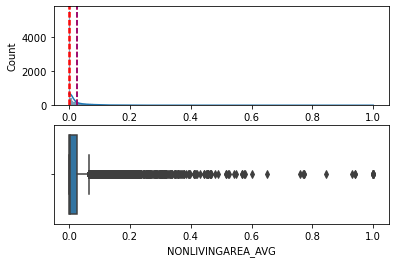

count    11351.000000
mean         0.026553
std          0.064684
min          0.000000
25%          0.000000
50%          0.002900
75%          0.025950
max          1.000000
Name: NONLIVINGAREA_AVG, dtype: float64

lower whisker: 0.0
upper whisker: 0.0648
outlier: [0.7729, 0.0906, 0.0772, 0.0897, 0.1428, 0.068, 0.0913, 0.3189, 0.0711, 0.0813, 0.2574, 0.2313, 0.14, 0.0702, 0.1746, 0.0892, 0.1254, 0.1046, 0.0869, 0.0956, 0.0923, 0.1348, 0.1338, 0.1351, 0.1098, 0.1514, 0.5168, 0.379, 0.0695, 0.1068, 0.077, 0.2613, 0.0699, 0.1038, 0.0755, 0.0693, 0.1165, 0.0653, 0.0685, 0.2252, 0.2515, 0.7709999999999999, 0.1137, 0.1853, 0.1866, 0.0723, 0.4161, 0.0847, 0.0752, 0.1034, 0.1437, 0.1252, 0.0956, 0.2584, 0.1259, 0.0716, 0.1521, 0.0674, 0.1503, 0.0775, 0.0681, 0.0949, 0.1089, 0.076, 0.0696, 0.0666, 0.4298, 0.1622, 0.0663, 0.0862, 0.1561, 0.0751, 0.1546, 0.0935, 0.2002, 0.1924, 0.1126, 0.159, 0.3349, 0.1037, 0.1228, 0.0798, 0.1643, 0.313, 0.212, 0.2205, 0.0951, 0.1062, 0.2452, 0.2331, 0.107, 0.

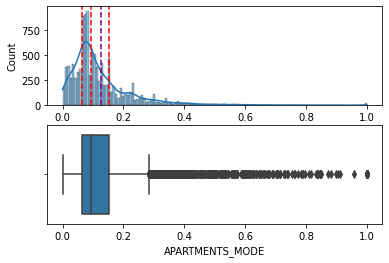

count    11351.000000
mean         0.126709
std          0.115311
min          0.000000
25%          0.063000
50%          0.094500
75%          0.151300
max          1.000000
Name: APARTMENTS_MODE, dtype: float64

lower whisker: 0.0
upper whisker: 0.2836
outlier: [0.5956, 0.3151, 0.4149, 0.3015, 0.4485, 0.2931, 0.5578, 0.5231, 0.3887, 0.2983, 0.3414, 0.3456, 0.3393, 0.3971, 0.3288, 0.3067, 0.3204, 0.3845, 0.3225, 0.5578, 0.6134, 0.4139, 0.3939, 0.3361, 1.0, 0.354, 0.3414, 0.52, 0.4139, 0.3099, 0.3361, 0.4023, 0.2973, 0.4538, 0.3782, 0.3372, 0.291, 0.5651, 0.3771, 0.3761, 0.3351, 0.3172, 0.3782, 0.6744, 0.3004, 0.2857, 0.3477, 0.2847, 0.73, 0.3403, 0.5011, 0.4023, 0.3109, 0.2952, 0.5042, 0.2931, 0.4842, 0.2994, 0.3015, 0.3824, 0.3025, 0.3571, 0.3487, 0.3151, 0.5294, 0.4517, 0.3792, 0.3025, 0.3025, 0.4905, 0.2983, 0.4884, 1.0, 0.3424, 0.4076, 0.3025, 0.5588, 0.3025, 0.3025, 0.2983, 0.7038, 0.3088, 0.5011, 0.3025, 0.3193, 0.3193, 0.2847, 0.3046, 0.2847, 0.4517, 0.3057, 0.3803, 0.3204, 0.

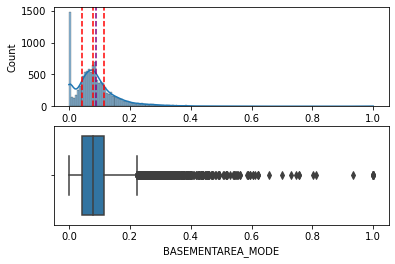

count    11351.000000
mean         0.090599
std          0.082629
min          0.000000
25%          0.043800
50%          0.077800
75%          0.115500
max          1.000000
Name: BASEMENTAREA_MODE, dtype: float64

lower whisker: 0.0
upper whisker: 0.223
outlier: [0.4742, 0.3002, 0.246, 0.2651, 0.4697, 0.3735, 0.2249, 0.3564, 0.2572, 0.5529999999999999, 0.2679, 0.2373, 0.3513, 0.4697, 0.339, 0.2269, 0.2259, 0.2326, 0.6585, 0.3268, 0.2944, 0.3066, 0.2377, 0.2719, 0.2766, 0.2436, 0.2575, 0.2681, 0.2249, 0.2737, 0.3439, 0.2471, 0.2538, 0.2408, 0.2874, 0.5899, 0.2642, 0.3885, 0.2441, 0.2392, 0.2238, 0.2559, 0.5151, 0.2389, 0.2302, 0.3304, 0.3962, 0.3019, 0.2717, 0.3678, 0.2795, 0.3454, 0.339, 0.2758, 0.4811, 0.2292, 0.2614, 0.2943, 0.4927, 0.2651, 1.0, 0.4026, 0.3522, 0.3132, 0.2271, 0.2436, 0.2799, 0.5167, 0.9338, 0.2663, 0.2494, 0.2325, 0.3142, 0.3405, 0.3707, 0.3021, 0.3159, 0.402, 0.2323, 0.4286, 0.49, 0.2595, 0.4109, 0.2747, 0.4362, 0.2538, 0.2513, 0.3515, 0.3835, 0.2326, 0.2371, 0.

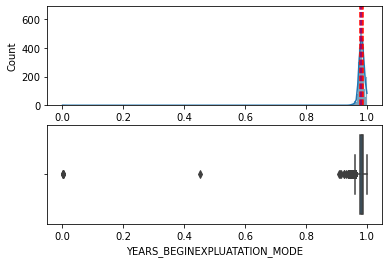

count    11351.000000
mean         0.982049
std          0.024530
min          0.000500
25%          0.977450
50%          0.982600
75%          0.987600
max          1.000000
Name: YEARS_BEGINEXPLUATATION_MODE, dtype: float64

lower whisker: 0.9623
upper whisker: 1.0
outlier: [0.9608, 0.9588, 0.9578, 0.9588, 0.9121, 0.9583, 0.9513, 0.9593, 0.9593, 0.9563, 0.9613, 0.9583, 0.9518, 0.9613, 0.9588, 0.9618, 0.9608, 0.9618, 0.9489, 0.9573, 0.9593, 0.9618, 0.9489, 0.9464, 0.9588, 0.9603, 0.9608, 0.9518, 0.9598, 0.9513, 0.9394, 0.9518, 0.9518, 0.9603, 0.9518, 0.9588, 0.9518, 0.0005, 0.9518, 0.0005, 0.9583, 0.9608, 0.9479, 0.9518, 0.9578, 0.9618, 0.9518, 0.9608, 0.9578, 0.9518, 0.9593, 0.9613, 0.9523, 0.9513, 0.9459, 0.9618, 0.9489, 0.9603, 0.9563, 0.0005, 0.9593, 0.0005, 0.9593, 0.9464, 0.9598, 0.9593, 0.9434, 0.9568, 0.9523, 0.9518, 0.9508, 0.9523, 0.9603, 0.9588, 0.9583, 0.9598, 0.9578, 0.9598, 0.9568, 0.9618, 0.9613, 0.9518, 0.9563, 0.9568, 0.9618, 0.9613, 0.9563, 0.9578, 0.9598, 0.9528, 0

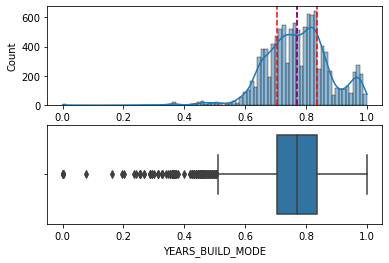

count    11351.000000
mean         0.771866
std          0.108451
min          0.000000
25%          0.706000
50%          0.771300
75%          0.836700
max          1.000000
Name: YEARS_BUILD_MODE, dtype: float64

lower whisker: 0.51
upper whisker: 1.0
outlier: [0.4838, 0.4577, 0.4446, 0.4577, 0.0, 0.4512, 0.3597, 0.4642, 0.4642, 0.425, 0.4904, 0.4512, 0.2552, 0.3662, 0.4577, 0.4969, 0.4838, 0.4969, 0.327, 0.4381, 0.4446, 0.4969, 0.327, 0.2944, 0.4577, 0.4773, 0.4838, 0.3662, 0.4708, 0.3597, 0.2029, 0.3662, 0.3662, 0.4773, 0.3662, 0.4577, 0.5034, 0.3989, 0.3662, 0.3662, 0.4512, 0.5034, 0.3532, 0.4838, 0.5034, 0.314, 0.5034, 0.3662, 0.4446, 0.4969, 0.3662, 0.4838, 0.4446, 0.3662, 0.4642, 0.4904, 0.3728, 0.3597, 0.2878, 0.4969, 0.327, 0.4773, 0.425, 0.4642, 0.4642, 0.2944, 0.4708, 0.4642, 0.2552, 0.4316, 0.3728, 0.3662, 0.3532, 0.3728, 0.4773, 0.4577, 0.4512, 0.4708, 0.4446, 0.4708, 0.5034, 0.0, 0.4316, 0.4904, 0.3662, 0.425, 0.4316, 0.4969, 0.4904, 0.425, 0.4446, 0.4708, 0.3793, 0.366

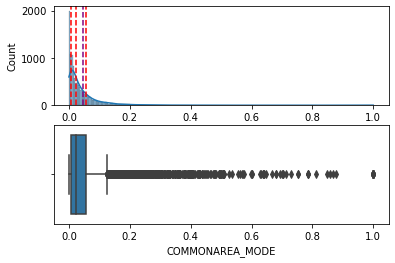

count    11351.000000
mean         0.046534
std          0.078669
min          0.000000
25%          0.007900
50%          0.022300
75%          0.055000
max          1.000000
Name: COMMONAREA_MODE, dtype: float64

lower whisker: 0.0
upper whisker: 0.1256
outlier: [0.35, 0.4724, 0.1502, 0.1445, 0.3474, 0.2844, 0.1703, 0.1398, 0.1283, 0.2766, 0.189, 0.3275, 0.1645, 0.4797, 0.1666, 0.2074, 0.1392, 0.1445, 0.1499, 0.1266, 0.2053, 0.1396, 0.4291, 1.0, 0.1588, 0.2813, 0.5694, 0.1692, 0.143, 0.3266, 0.2933, 0.2494, 0.2278, 0.1413, 0.1415, 0.2288, 0.2921, 0.1598, 0.1407, 0.1336, 0.3648, 0.2194, 0.1754, 0.1711, 0.2576, 0.1725, 0.2208, 1.0, 0.159, 0.1542, 0.2137, 0.3579, 0.1831, 0.1895, 0.1578, 0.292, 0.2837, 0.2217, 0.1427, 0.1947, 0.1775, 0.1282, 0.5553, 0.1464, 0.1374, 0.4259, 0.2547, 0.2407, 0.129, 0.1482, 0.198, 0.1652, 0.1259, 0.1279, 0.143, 1.0, 0.142, 0.1473, 0.2152, 0.2007, 1.0, 0.4522, 0.2911, 0.1703, 0.1673, 0.1309, 0.6392, 0.1826, 0.1718, 0.6392, 0.2074, 0.1439, 0.1363, 0.1911, 0.15

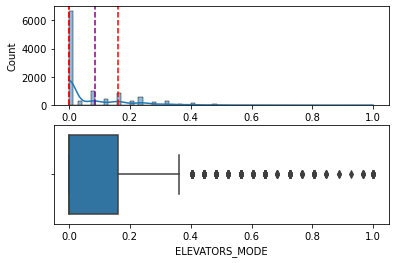

count    11351.000000
mean         0.084923
std          0.140981
min          0.000000
25%          0.000000
50%          0.000000
75%          0.161100
max          1.000000
Name: ELEVATORS_MODE, dtype: float64

lower whisker: 0.0
upper whisker: 0.3625
outlier: [0.6042, 0.4028, 0.4431, 0.4028, 0.6042, 0.5639, 0.4834, 0.4431, 0.6445, 0.4834, 0.6042, 0.4431, 0.4834, 0.4834, 0.4028, 0.5236, 0.4028, 0.6445, 0.4028, 0.4834, 0.4028, 0.4834, 0.6445, 0.4028, 0.4028, 0.4028, 0.725, 0.4028, 0.8056, 0.725, 0.4028, 0.4834, 0.4834, 0.6445, 0.4834, 0.4028, 0.4028, 0.4834, 0.5639, 0.4834, 0.4431, 0.4028, 0.5236, 0.4028, 1.0, 0.4834, 0.6445, 0.4028, 0.8056, 0.4834, 0.4028, 0.4834, 0.4028, 0.4028, 0.4028, 0.5639, 0.4431, 0.6445, 0.5639, 1.0, 0.4431, 0.5639, 1.0, 0.4834, 0.4834, 0.5236, 0.8056, 1.0, 0.4028, 0.5639, 0.725, 0.4431, 0.4028, 0.4834, 0.5639, 0.4028, 0.6445, 0.4834, 0.4834, 0.5639, 0.4834, 0.4834, 0.4834, 0.5639, 0.5639, 0.4834, 0.7653, 0.6445, 0.4834, 0.4028, 0.4834, 0.4431, 0.4028, 0.4834

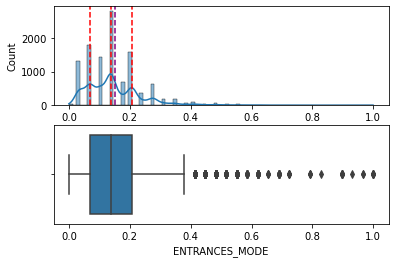

count    11351.000000
mean         0.150345
std          0.100113
min          0.000000
25%          0.069000
50%          0.137900
75%          0.206900
max          1.000000
Name: ENTRANCES_MODE, dtype: float64

lower whisker: 0.0
upper whisker: 0.3793
outlier: [0.6207, 0.5172, 0.4828, 0.8276, 0.6897, 0.5172, 0.4483, 1.0, 0.6897, 0.4828, 0.4138, 0.4828, 0.4828, 0.6207, 0.4138, 0.8966, 0.4138, 0.6207, 0.4828, 0.4138, 0.4138, 0.4483, 0.4828, 0.4138, 0.5517, 0.4138, 0.4483, 0.4828, 0.4138, 0.4138, 0.8966, 0.4828, 0.4828, 0.8966, 0.4483, 0.5172, 0.5172, 0.4138, 0.4828, 0.4138, 0.4828, 0.5517, 0.4138, 0.4138, 0.4138, 0.4138, 0.4138, 0.4138, 0.4138, 0.6552, 0.4138, 0.5172, 0.4483, 0.4138, 0.4138, 0.4828, 0.4138, 0.4828, 0.4138, 0.5517, 0.4138, 0.4483, 0.4483, 0.5172, 0.5517, 0.4138, 0.931, 0.4483, 0.4138, 0.5517, 0.4138, 0.4138, 0.4828, 0.6897, 0.4138, 0.4138, 0.5172, 0.5172, 0.4828, 0.7241, 0.4138, 0.4138, 0.5172, 0.4138, 0.5517, 0.4828, 0.4138, 0.6207, 0.8966, 0.4483, 0.4483, 0.4138, 0.4

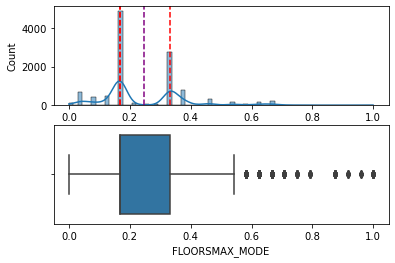

count    11351.000000
mean         0.247746
std          0.151053
min          0.000000
25%          0.166700
50%          0.166700
75%          0.333300
max          1.000000
Name: FLOORSMAX_MODE, dtype: float64

lower whisker: 0.0
upper whisker: 0.5417
outlier: [0.9167, 0.6667, 0.625, 0.6667, 0.5833, 0.625, 0.625, 0.5833, 0.625, 0.625, 0.6667, 0.625, 0.875, 0.625, 0.625, 0.7917, 0.6667, 0.6667, 0.6667, 0.625, 0.6667, 0.75, 0.6667, 0.625, 0.625, 0.625, 0.625, 0.6667, 0.625, 0.625, 0.7083, 0.6667, 0.5833, 0.875, 0.6667, 0.875, 0.625, 0.7083, 0.625, 0.625, 0.6667, 0.6667, 1.0, 0.625, 0.5833, 0.625, 0.625, 0.875, 0.7083, 0.625, 0.625, 0.625, 0.6667, 1.0, 0.625, 0.6667, 0.6667, 0.6667, 0.7917, 0.625, 0.5833, 0.6667, 0.6667, 0.6667, 0.6667, 0.625, 0.625, 0.6667, 0.625, 0.625, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.625, 0.6667, 0.5833, 0.625, 0.5833, 0.6667, 0.625, 0.5833, 0.625, 0.6667, 0.875, 0.6667, 1.0, 0.6667, 0.625, 0.625, 1.0, 0.625, 0.7083, 0.625, 0.6667, 0.625, 0.625, 0.6667, 0.

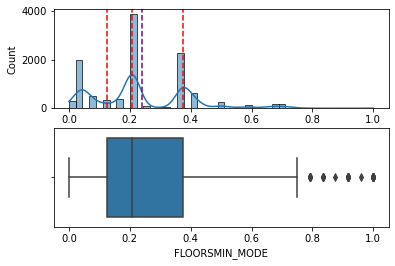

count    11351.000000
mean         0.241384
std          0.166071
min          0.000000
25%          0.125000
50%          0.208300
75%          0.375000
max          1.000000
Name: FLOORSMIN_MODE, dtype: float64

lower whisker: 0.0
upper whisker: 0.75
outlier: [0.9167, 0.8333, 0.7917, 1.0, 1.0, 0.9167, 0.9167, 1.0, 1.0, 1.0, 1.0, 0.9167, 1.0, 0.8333, 1.0, 1.0, 0.7917, 1.0, 0.7917, 1.0, 0.9167, 0.875, 0.8333, 0.9167, 1.0, 1.0, 0.8333, 0.9583, 1.0, 1.0, 1.0, 0.7917, 0.7917, 0.9167, 0.9167, 0.9167, 0.7917, 0.8333, 0.9167, 0.9167, 0.9167, 0.7917, 1.0, 1.0]
outlier count: 44
Data skewed dengan nilai p-value 4.5550238147253186e-238 dan skew 0.8699789515142251
55. LANDAREA_MODE



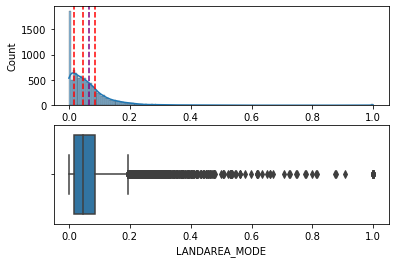

count    11351.000000
mean         0.067064
std          0.085844
min          0.000000
25%          0.016500
50%          0.046800
75%          0.087100
max          1.000000
Name: LANDAREA_MODE, dtype: float64

lower whisker: 0.0
upper whisker: 0.193
outlier: [0.2912, 0.4195, 0.3177, 0.2824, 0.297, 0.6352, 1.0, 0.3256, 0.1967, 0.2728, 0.2319, 0.2582, 0.3271, 0.7778, 0.297, 0.2103, 0.2372, 0.523, 0.5339, 0.4389, 0.333, 0.2076, 0.2748, 0.3093, 0.2991, 0.2203, 0.2047, 0.2095, 0.2447, 0.4625, 0.1965, 0.3068, 0.355, 0.2069, 0.2298, 0.2203, 0.2881, 0.8107, 1.0, 0.4335, 0.2259, 0.2045, 0.2056, 0.2306, 0.2761, 0.1971, 0.3683, 0.259, 0.2494, 0.1934, 0.3301, 0.5007, 0.2174, 0.3729, 0.2178, 0.2426, 0.2026, 0.2168, 0.2013, 0.2142, 0.2317, 0.2179, 0.3316, 0.3928, 0.2883, 0.1945, 0.2688, 0.3196, 0.4714, 0.1961, 0.1947, 0.2287, 0.3468, 0.2255, 0.3149, 0.3187, 0.2031, 0.2599, 0.4443, 0.2208, 0.2518, 0.3143, 0.4223, 0.2003, 0.23, 0.2654, 0.2714, 0.2817, 0.3309, 0.3606, 0.3054, 0.2311, 0.2227, 0.2922,

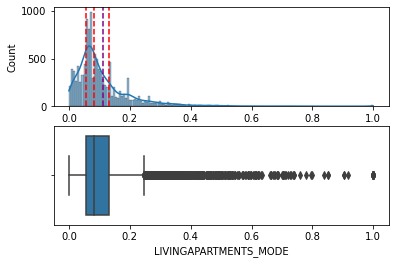

count    11351.000000
mean         0.111081
std          0.102753
min          0.000000
25%          0.055100
50%          0.081700
75%          0.132200
max          1.000000
Name: LIVINGAPARTMENTS_MODE, dtype: float64

lower whisker: 0.0
upper whisker: 0.247
outlier: [0.4683, 0.2755, 0.3563, 0.2626, 0.3921, 0.2562, 0.4867, 0.4536, 0.337, 0.2608, 0.2874, 0.3021, 0.2966, 0.3471, 0.2635, 0.281, 0.2681, 0.2645, 0.2801, 0.3333, 0.2645, 0.4867, 0.5363, 0.3618, 0.3581, 0.337, 0.2938, 0.3095, 0.2911, 0.4545, 0.348, 0.2479, 0.2709, 0.2681, 0.3517, 0.259, 0.3967, 0.3306, 0.292, 0.2498, 0.4858, 0.3297, 0.3287, 0.2902, 0.3306, 0.5895, 0.2626, 0.2489, 0.303, 0.2479, 0.6162, 0.2975, 0.4353, 0.3517, 0.2718, 0.2498, 0.4408, 0.2562, 0.4132, 0.2617, 0.393, 0.3324, 0.2645, 0.3113, 0.3039, 0.2681, 0.4628, 0.3921, 0.3297, 0.2645, 0.2626, 0.4279, 0.2608, 0.4242, 1.0, 0.2984, 0.3526, 0.2626, 0.4885, 0.2617, 0.2635, 0.2635, 0.2608, 0.6125, 0.5473, 0.2681, 0.438, 0.2635, 0.2773, 0.2782, 0.2479, 0.2626, 0.621

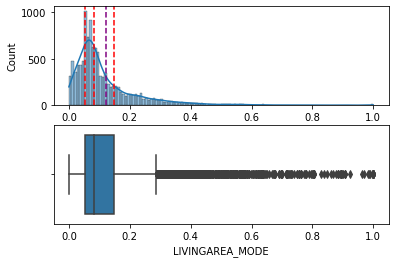

count    11351.000000
mean         0.120898
std          0.121477
min          0.000000
25%          0.053000
50%          0.081700
75%          0.146950
max          1.000000
Name: LIVINGAREA_MODE, dtype: float64

lower whisker: 0.0
upper whisker: 0.2877
outlier: [0.7488, 0.3713, 0.4306, 0.3348, 0.3551, 0.3082, 0.6355, 0.5221, 0.3736, 0.2945, 0.3764, 0.349, 0.3536, 0.4394, 0.3229999999999999, 0.4098, 0.3282, 0.2985, 0.3311, 0.4494, 0.426, 0.6355, 0.5859, 0.2897, 0.3929, 0.3593, 0.3634, 0.4294, 0.3505, 0.4086, 0.3243, 0.3524, 0.3095, 0.2937, 0.4001, 0.4813, 0.406, 0.3152, 0.2941, 0.3699, 0.3259, 0.7337, 0.2941, 0.4046, 0.3893, 0.4052, 0.7287, 0.3416, 0.2899, 0.3218, 0.3861, 0.7566, 0.3588, 0.3994, 0.3804, 0.5867, 0.3322, 0.5218, 0.4374, 0.3629, 0.4135, 0.5121, 0.2939, 0.3248, 0.3958, 0.3124, 0.3004, 0.5617, 0.3056, 0.5588, 0.3674, 0.3101, 0.407, 0.3034, 0.3226, 0.2897, 0.5854, 0.5327, 1.0, 0.3658, 0.4243, 0.317, 0.6149, 0.3385, 0.8829, 0.292, 0.7001, 0.3319, 0.3008, 0.4719, 0.3273, 0.3

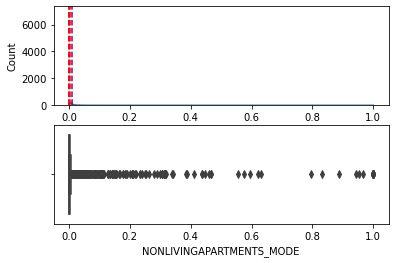

count    11351.000000
mean         0.008506
std          0.047862
min          0.000000
25%          0.000000
50%          0.000000
75%          0.003900
max          1.000000
Name: NONLIVINGAPARTMENTS_MODE, dtype: float64

lower whisker: 0.0
upper whisker: 0.0078
outlier: [0.2218, 0.0272, 0.0623, 0.0117, 0.0117, 0.0272, 0.0117, 0.0156, 0.0117, 0.0117, 0.0195, 0.0467, 0.0195, 0.0156, 0.0156, 0.0117, 0.0545, 0.0117, 0.0272, 0.0117, 0.0195, 0.0117, 0.035, 0.0233, 0.0117, 0.0117, 0.0156, 0.0156, 0.0117, 0.0117, 0.0739, 0.0389, 0.0195, 0.144, 0.035, 0.0117, 0.0311, 0.0156, 0.0117, 0.0233, 0.0311, 0.0117, 0.07, 0.0117, 0.0233, 0.0156, 0.0117, 0.0117, 0.0233, 0.0311, 0.0117, 0.035, 0.0156, 0.0311, 0.2101, 0.0117, 0.0584, 0.0117, 0.0117, 0.0389, 0.1089, 0.0117, 0.0311, 0.0195, 0.0117, 0.0195, 0.035, 0.0156, 0.0661, 0.0311, 0.0156, 0.0117, 0.0311, 0.0195, 0.0311, 0.07, 0.0156, 0.5953, 0.0156, 0.0817, 0.0117, 0.0117, 0.0311, 0.0272, 0.0195, 0.0195, 0.0117, 0.0195, 0.035, 0.0934, 0.0117, 0.0117,

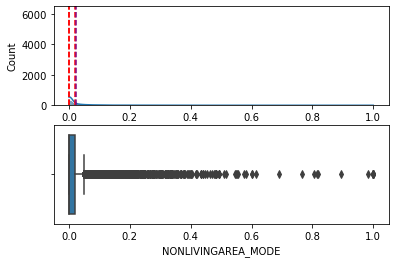

count    11351.000000
mean         0.024052
std          0.062988
min          0.000000
25%          0.000000
50%          0.000000
75%          0.019300
max          1.000000
Name: NONLIVINGAREA_MODE, dtype: float64

lower whisker: 0.0
upper whisker: 0.0482
outlier: [0.8183, 0.0576, 0.0959, 0.0486, 0.0651, 0.0817, 0.095, 0.1511, 0.0719, 0.0816, 0.3376, 0.0753, 0.0861, 0.2725, 0.2449, 0.0578, 0.0607, 0.0619, 0.1482, 0.0638, 0.057, 0.0743, 0.1848, 0.0945, 0.1328, 0.1108, 0.1012, 0.0663, 0.0977, 0.1427, 0.1417, 0.0647, 0.1163, 0.1603, 0.059, 0.0625, 0.5472, 0.4012, 0.0736, 0.1131, 0.0815, 0.2767, 0.074, 0.0684, 0.0799, 0.0589, 0.0733, 0.1233, 0.0632, 0.0685, 0.0573, 0.0498, 0.0692, 0.0725, 0.2384, 0.0514, 0.2663, 0.0508, 0.0545, 0.1203, 0.0491, 0.1962, 0.2963, 0.4405, 0.0896, 0.0796, 0.1095, 0.1522, 0.1325, 0.0758, 0.0704, 0.0713, 0.0625, 0.1591, 0.0821, 0.0721, 0.1005, 0.1152, 0.0805, 0.0559, 0.0737, 0.0705, 0.4551, 0.1717, 0.0702, 0.0913, 0.0616, 0.1652, 0.0556, 0.1636, 0.072, 0.2036, 

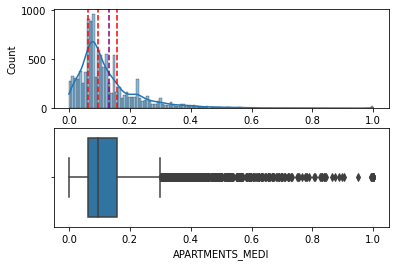

count    11351.000000
mean         0.131447
std          0.115891
min          0.000000
25%          0.062500
50%          0.094700
75%          0.158200
max          1.000000
Name: APARTMENTS_MEDI, dtype: float64

lower whisker: 0.0
upper whisker: 0.3008
outlier: [0.5902, 0.3123, 0.4112, 0.4616, 0.4445, 0.5527, 0.5184, 0.3851, 0.3154, 0.3966, 0.3383, 0.3425, 0.3362, 0.3935, 0.3258, 0.3039, 0.3263, 0.3175, 0.381, 0.3196, 0.5527, 0.6079, 0.4101, 0.4112, 0.3903, 0.3331, 1.0, 0.3508, 0.3383, 0.5153, 0.4101, 0.3071, 0.3331, 0.3987, 0.4497, 0.3747, 0.3341, 0.3341, 0.56, 0.3737, 0.3726, 0.3321, 0.3144, 0.3747, 0.6683, 0.3726, 0.3726, 0.3445, 0.7234, 0.3373, 0.4965, 0.3987, 0.3081, 0.4944, 0.4996, 0.4799, 0.3721, 0.3789, 0.3539, 0.3456, 0.3123, 0.5246, 0.4476, 0.3758, 0.4861, 0.484, 1.0, 0.3393, 0.4039, 0.5538, 0.6974, 0.3955, 0.3123, 0.306, 0.4965, 0.3164, 0.3164, 0.3019, 0.4476, 0.3029, 0.4601, 0.3768, 0.3175, 0.4039, 0.33, 0.3112, 0.3924, 0.4767, 0.3716, 0.3747, 0.3565, 0.5163, 0.4851, 0.6

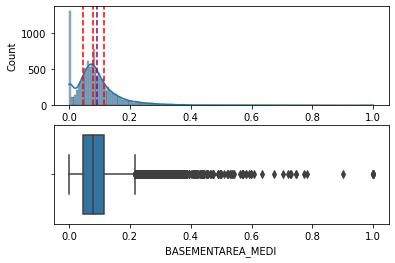

count    11351.000000
mean         0.091753
std          0.080612
min          0.000000
25%          0.047400
50%          0.078700
75%          0.115500
max          1.000000
Name: BASEMENTAREA_MEDI, dtype: float64

lower whisker: 0.0
upper whisker: 0.2175
outlier: [0.457, 0.2893, 0.2371, 0.2555, 0.4526, 0.3599, 0.3434, 0.2478, 0.5329, 0.2582, 0.3082, 0.3386, 0.4526, 0.3266, 0.2255, 0.2177, 0.2235, 0.2242, 0.3855, 0.6345, 0.3149, 0.2837, 0.2955, 0.2291, 0.262, 0.2665, 0.2347, 0.2332, 0.2482, 0.2583, 0.2325, 0.2638, 0.3314, 0.2381, 0.2445, 0.2321, 0.277, 0.5685, 0.2545, 0.3744, 0.2353, 0.2305, 0.2466, 0.4964, 0.2302, 0.2218, 0.3184, 0.2842, 0.3818, 0.2909, 0.2618, 0.3545, 0.2693, 0.3329, 0.3267, 0.2657, 0.4636, 0.2209, 0.2519, 0.2836, 0.4748, 0.2555, 1.0, 0.388, 0.3394, 0.3018, 0.2197, 0.2188, 0.2348, 0.2697, 0.4979, 0.8998, 0.2566, 0.2404, 0.3367, 0.2241, 0.3027, 0.3331, 0.3572, 0.2911, 0.3044, 0.3874, 0.2239, 0.413, 0.4722, 0.2501, 0.396, 0.2647, 0.4204, 0.2367, 0.2446, 0.2422, 0.338

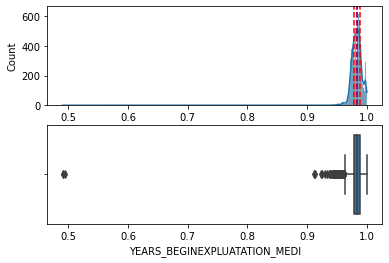

count    11351.000000
mean         0.982772
std          0.011375
min          0.490300
25%          0.977600
50%          0.983100
75%          0.987600
max          1.000000
Name: YEARS_BEGINEXPLUATATION_MEDI, dtype: float64

lower whisker: 0.9627
upper whisker: 1.0
outlier: [0.9608, 0.9588, 0.9588, 0.9121, 0.9593, 0.9513, 0.9593, 0.9593, 0.9563, 0.9613, 0.9583, 0.9518, 0.9588, 0.9617, 0.9608, 0.9617, 0.9488, 0.9573, 0.9617, 0.9463, 0.9588, 0.9603, 0.9608, 0.9518, 0.9598, 0.9513, 0.9394, 0.9518, 0.9518, 0.9603, 0.9518, 0.9588, 0.9622, 0.9518, 0.4903, 0.9583, 0.9622, 0.9553, 0.9608, 0.9622, 0.9478, 0.9622, 0.9518, 0.9578, 0.9617, 0.9518, 0.9608, 0.9578, 0.9518, 0.9593, 0.9613, 0.9513, 0.9459, 0.9617, 0.9488, 0.9603, 0.9563, 0.9593, 0.9593, 0.9463, 0.9598, 0.9593, 0.9434, 0.9568, 0.9523, 0.9518, 0.9508, 0.9523, 0.9603, 0.9588, 0.9583, 0.9598, 0.9578, 0.9598, 0.9622, 0.9617, 0.9613, 0.9518, 0.9563, 0.9568, 0.9617, 0.9563, 0.9578, 0.9598, 0.9528, 0.9518, 0.9473, 0.9603, 0.9434, 0.9573, 0

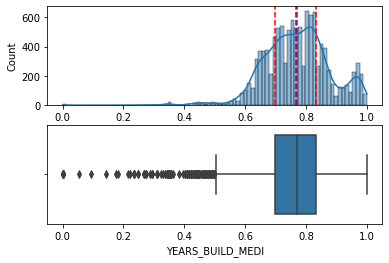

count    11351.000000
mean         0.768614
std          0.110298
min          0.000000
25%          0.698100
50%          0.771900
75%          0.832300
max          1.000000
Name: YEARS_BUILD_MEDI, dtype: float64

lower whisker: 0.5035
upper whisker: 1.0
outlier: [0.47, 0.4968, 0.4431, 0.4431, 0.0, 0.4499, 0.3425, 0.4499, 0.4499, 0.4096, 0.4767, 0.4364, 0.2352, 0.4968, 0.3492, 0.4431, 0.4834, 0.47, 0.4834, 0.309, 0.423, 0.4297, 0.4834, 0.2754, 0.4431, 0.4633, 0.47, 0.3492, 0.4566, 0.3425, 0.1815, 0.3492, 0.3492, 0.4633, 0.3492, 0.4431, 0.4901, 0.3828, 0.3492, 0.3492, 0.4968, 0.4364, 0.4901, 0.3962, 0.47, 0.4901, 0.2955, 0.4901, 0.3492, 0.4297, 0.4834, 0.3492, 0.47, 0.4297, 0.3492, 0.4968, 0.4968, 0.4499, 0.4767, 0.4968, 0.3425, 0.2687, 0.4834, 0.309, 0.4633, 0.4096, 0.4499, 0.4499, 0.2754, 0.4566, 0.4499, 0.2352, 0.4163, 0.3559, 0.4968, 0.3492, 0.3358, 0.3559, 0.4633, 0.4431, 0.4364, 0.4566, 0.4297, 0.4968, 0.4566, 0.4901, 0.0, 0.4163, 0.4767, 0.3492, 0.4096, 0.4163, 0.4834, 0.4096, 

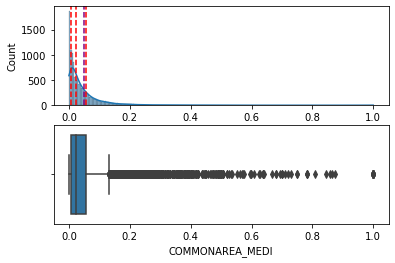

count    11351.000000
mean         0.048998
std          0.080503
min          0.000000
25%          0.008400
50%          0.024500
75%          0.057750
max          1.000000
Name: COMMONAREA_MEDI, dtype: float64

lower whisker: 0.0
upper whisker: 0.1317
outlier: [0.349, 0.4711, 0.1498, 0.1441, 0.1508, 0.3464, 0.2837, 0.1698, 0.1395, 0.2758, 0.1884, 0.355, 0.1641, 0.4812, 0.1661, 0.2069, 0.1388, 0.1441, 0.1495, 0.2047, 0.1392, 0.4943, 1.0, 0.1584, 0.2805, 0.5678, 0.1688, 0.1426, 0.3257, 0.2925, 0.2487, 0.2272, 0.1409, 0.1411, 0.2281, 0.2913, 0.1594, 0.1403, 0.1333, 0.3638, 0.2188, 0.1749, 0.1706, 0.2569, 0.172, 0.2202, 1.0, 0.2607, 0.1538, 0.2131, 0.3569, 0.2136, 0.1825, 0.189, 0.1574, 0.2912, 0.2829, 0.2211, 0.1423, 0.1941, 0.177, 0.5538, 0.146, 0.1369999999999999, 0.4247, 0.254, 0.24, 0.1334, 0.1478, 0.148, 0.1974, 0.1647, 0.3689, 0.1426, 1.0, 0.1416, 0.1469, 0.2147, 0.2002, 1.0, 0.4509, 0.2903, 0.1698, 0.1668, 0.1818, 0.6374, 0.3785, 0.1821, 0.1553, 0.1714, 0.6374, 0.207, 0.1876, 0

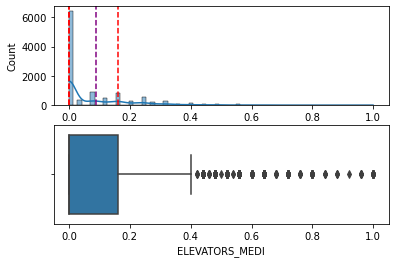

count    11351.000000
mean         0.089522
std          0.143308
min          0.000000
25%          0.000000
50%          0.000000
75%          0.160000
max          1.000000
Name: ELEVATORS_MEDI, dtype: float64

lower whisker: 0.0
upper whisker: 0.4
outlier: [0.6, 0.44, 0.44, 0.6, 0.56, 0.64, 0.44, 0.64, 0.42, 0.48, 0.6, 0.44, 0.48, 0.48, 0.52, 0.68, 0.64, 0.48, 0.48, 0.64, 0.72, 0.52, 0.52, 0.8, 0.72, 0.48, 0.48, 0.48, 0.64, 0.48, 0.48, 0.56, 0.48, 0.44, 0.52, 1.0, 0.48, 0.64, 0.8, 0.48, 0.48, 0.56, 0.44, 0.64, 0.56, 1.0, 0.48, 0.44, 0.56, 1.0, 0.48, 0.48, 0.52, 0.8, 1.0, 0.56, 0.72, 0.44, 0.48, 0.56, 0.64, 0.48, 0.48, 0.88, 0.44, 0.48, 0.48, 0.56, 0.56, 0.52, 0.48, 0.76, 0.64, 0.48, 0.48, 0.44, 0.48, 0.44, 0.44, 0.56, 0.8, 0.48, 0.48, 0.64, 0.48, 0.52, 0.76, 0.64, 0.64, 0.64, 0.44, 0.52, 0.56, 0.48, 0.44, 0.64, 0.48, 0.44, 0.48, 0.8, 0.96, 0.44, 0.44, 0.64, 0.48, 0.6, 0.56, 0.64, 0.56, 0.56, 0.48, 0.72, 0.48, 0.6, 0.64, 0.48, 0.72, 0.52, 0.56, 0.8, 0.48, 0.52, 0.64, 0.48, 0.56, 0.4

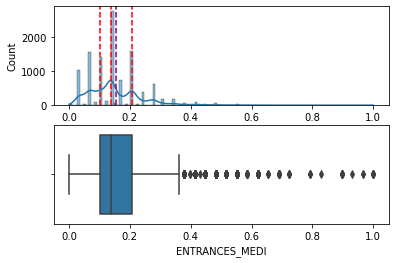

count    11351.000000
mean         0.155214
std          0.098734
min          0.000000
25%          0.103400
50%          0.137900
75%          0.206900
max          1.000000
Name: ENTRANCES_MEDI, dtype: float64

lower whisker: 0.0
upper whisker: 0.3621
outlier: [0.3793, 0.6207, 0.5172, 0.3793, 0.4828, 0.8276, 0.6897, 0.5172, 0.3793, 0.4483, 1.0, 0.6897, 0.4828, 0.4138, 0.4828, 0.4828, 0.6207, 0.4138, 0.3793, 0.8966, 0.4138, 0.6207, 0.4828, 0.4138, 0.4138, 0.4483, 0.4828, 0.4138, 0.5517, 0.4138, 0.4483, 0.4828, 0.4138, 0.4138, 0.8966, 0.4828, 0.4828, 0.3793, 0.8966, 0.4483, 0.5172, 0.5172, 0.3793, 0.4138, 0.4828, 0.4138, 0.4828, 0.5517, 0.4138, 0.4138, 0.4138, 0.3793, 0.4138, 0.4138, 0.4138, 0.3793, 0.4138, 0.6552, 0.4138, 0.3793, 0.5172, 0.4483, 0.4138, 0.4138, 0.3793, 0.4828, 0.4138, 0.4828, 0.4138, 0.5517, 0.4138, 0.4483, 0.4483, 0.5172, 0.5517, 0.3793, 0.4138, 0.931, 0.4483, 0.4138, 0.3793, 0.5517, 0.4138, 0.4138, 0.4828, 0.3793, 0.6897, 0.3793, 0.4138, 0.3793, 0.4138, 0.5172, 0.5

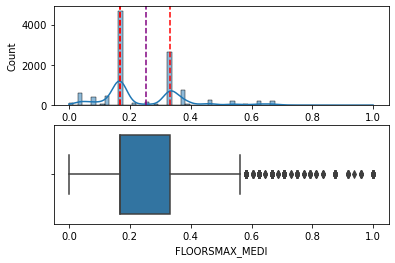

count    11351.000000
mean         0.252789
std          0.152460
min          0.000000
25%          0.166700
50%          0.166700
75%          0.333300
max          1.000000
Name: FLOORSMAX_MEDI, dtype: float64

lower whisker: 0.0
upper whisker: 0.5625
outlier: [0.9167, 0.6667, 0.625, 0.6667, 0.5833, 0.625, 0.625, 0.5833, 0.625, 0.625, 0.6667, 0.625, 0.875, 0.7292, 0.625, 0.625, 0.7917, 0.6667, 0.6667, 0.6667, 0.625, 0.6667, 0.75, 0.6667, 0.625, 0.625, 0.625, 0.625, 0.6667, 0.625, 0.625, 0.7083, 0.6667, 0.6042, 1.0, 0.6667, 0.875, 0.75, 0.7083, 0.625, 0.625, 0.6667, 0.6667, 1.0, 0.625, 0.5833, 0.625, 0.625, 0.875, 0.7083, 0.625, 0.625, 0.625, 0.6667, 1.0, 0.625, 0.6667, 0.6667, 0.6667, 0.8333, 0.625, 0.5833, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.625, 0.625, 0.6667, 0.625, 0.625, 0.6667, 0.6667, 0.7083, 0.6667, 0.6667, 0.625, 0.6667, 0.5833, 0.625, 0.5833, 0.6667, 0.625, 0.5833, 0.625, 0.6667, 0.875, 0.6667, 1.0, 0.6667, 0.625, 0.625, 1.0, 0.625, 0.7083, 0.625, 0.6667, 0.6

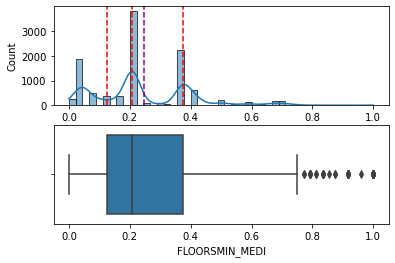

count    11351.000000
mean         0.245530
std          0.166573
min          0.000000
25%          0.125000
50%          0.208300
75%          0.375000
max          1.000000
Name: FLOORSMIN_MEDI, dtype: float64

lower whisker: 0.0
upper whisker: 0.75
outlier: [0.9167, 0.8333, 0.7917, 1.0, 1.0, 0.9167, 0.9167, 1.0, 0.7708, 1.0, 1.0, 1.0, 0.9167, 1.0, 0.8333, 1.0, 1.0, 0.7917, 0.7708, 1.0, 0.7917, 1.0, 0.9167, 0.875, 0.8333, 0.9167, 1.0, 0.8333, 1.0, 0.8333, 0.9583, 0.8125, 1.0, 0.8542, 1.0, 1.0, 0.7917, 0.7917, 0.9167, 0.9167, 0.9167, 0.7917, 0.875, 0.8333, 0.9167, 0.9167, 0.9167, 0.7917, 1.0, 0.8125, 1.0]
outlier count: 51
Data skewed dengan nilai p-value 5.573129934905242e-237 dan skew 0.867429785142305
69. LANDAREA_MEDI



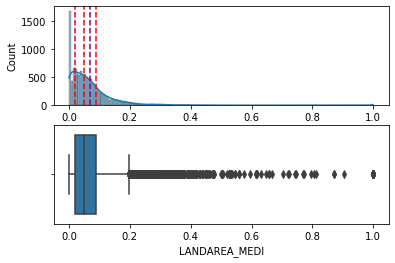

count    11351.000000
mean         0.069674
std          0.086078
min          0.000000
25%          0.019300
50%          0.050200
75%          0.090100
max          1.000000
Name: LANDAREA_MEDI, dtype: float64

lower whisker: 0.0
upper whisker: 0.1961
outlier: [0.2896, 0.4173, 0.316, 0.2809, 0.2954, 0.6318, 1.0, 0.3239, 0.2714, 0.2306, 0.2568, 0.3254, 0.7737, 0.2954, 0.2092, 0.236, 0.5202, 0.5311, 0.4366, 0.3312, 0.2065, 0.2733, 0.3076, 0.2975, 0.2191, 0.2036, 0.2084, 0.2434, 0.4601, 0.3052, 0.3531, 0.2058, 0.2286, 0.2191, 0.2866, 0.8064, 1.0, 0.4312, 0.2247, 0.2034, 0.2045, 0.2294, 0.2746, 0.3664, 0.2576, 0.248, 0.3283, 0.4981, 0.2162, 0.3709, 0.2166, 0.2413, 0.2015, 0.2156, 0.2002, 0.213, 0.3519, 0.2305, 0.2167, 0.3299, 0.3907, 0.2867, 0.2674, 0.3179, 0.4689, 0.2062, 0.2274, 0.345, 0.2243, 0.3133, 0.317, 0.202, 0.2585, 0.4419, 0.2196, 0.2504, 0.3127, 0.42, 0.1992, 0.2288, 0.264, 0.2699, 0.2802, 0.3291, 0.3587, 0.3038, 0.2299, 0.2215, 0.31, 0.3709, 0.3142, 0.3083, 0.276, 0.2644, 0.4

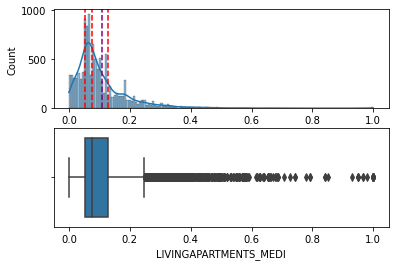

count    11351.000000
mean         0.107490
std          0.098355
min          0.000000
25%          0.051300
50%          0.077000
75%          0.130000
max          1.000000
Name: LIVINGAPARTMENTS_MEDI, dtype: float64

lower whisker: 0.0
upper whisker: 0.248
outlier: [0.4361, 0.2565, 0.3318, 0.3792, 0.3651, 0.4532, 0.4224, 0.3138, 0.3258, 0.2676, 0.2813, 0.2762, 0.3232, 0.2617, 0.2497, 0.257, 0.2608, 0.3104, 0.4532, 0.4994, 0.3369, 0.3335, 0.3138, 0.2736, 0.2882, 1.0, 0.2711, 0.5276, 0.4233, 0.3241, 0.2522, 0.2497, 0.3275, 0.3694, 0.3078, 0.2719, 0.2745, 0.4523, 0.307, 0.3061, 0.2702, 0.3078, 0.5489999999999999, 0.3061, 0.2822, 0.5738, 0.277, 0.4053, 0.3275, 0.2531, 0.4104, 0.3848, 0.366, 0.3095, 0.2899, 0.283, 0.2497, 0.431, 0.3651, 0.307, 0.3985, 0.395, 1.0, 0.2779, 0.3284, 0.4549, 0.5703, 0.5096, 0.2531, 0.2497, 0.4079, 0.2582, 0.2591, 0.5789, 0.3664, 0.2488, 0.3779, 0.3061, 0.2591, 0.3292, 0.2591, 0.3258, 0.2548, 0.3224, 0.3856, 0.3036, 0.2959, 0.3113, 0.3933, 0.3976, 0.4994, 0.2

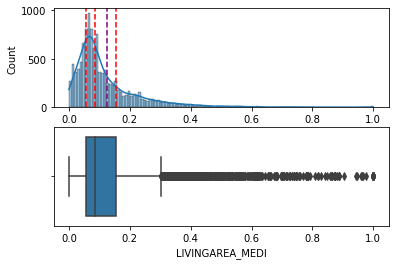

count    11351.000000
mean         0.125140
std          0.121773
min          0.000000
25%          0.054600
50%          0.085900
75%          0.153950
max          1.000000
Name: LIVINGAREA_MEDI, dtype: float64

lower whisker: 0.0
upper whisker: 0.3027
outlier: [0.7317, 0.3628, 0.4207, 0.3271, 0.4669, 0.3469, 0.621, 0.5102, 0.365, 0.3345, 0.3859, 0.3678, 0.3409, 0.3455, 0.4293, 0.3156, 0.4004, 0.3529, 0.3222, 0.3254, 0.3235, 0.4391, 0.4162, 0.621, 0.5735, 0.3068, 0.446, 0.3838, 0.3511, 0.355, 0.4195, 0.8879, 0.3424, 0.3992, 0.3169, 0.3443, 0.3909, 0.4703, 0.3967, 0.308, 0.3614, 0.3296, 0.3184, 0.7168, 0.3953, 0.3803, 0.3959, 0.7120000000000001, 0.3338, 0.4, 0.3824, 0.3144, 0.3388, 0.3773, 0.7392, 0.3505, 0.3902, 0.3716, 0.531, 0.5733, 0.3268, 0.5099, 0.4274, 0.3546, 0.404, 0.5004, 0.3174, 0.3868, 0.3052, 0.5488, 0.5459, 0.3589, 0.303, 0.3976, 0.3152, 0.5720000000000001, 0.5204, 1.0, 0.3574, 0.4146, 0.3098, 0.6008, 0.3307, 0.8626, 0.684, 0.3934, 0.4611, 0.3198, 0.3114, 0.3243, 0.3087

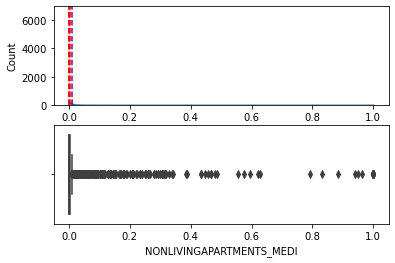

count    11351.000000
mean         0.009181
std          0.048737
min          0.000000
25%          0.000000
50%          0.000000
75%          0.003900
max          1.000000
Name: NONLIVINGAPARTMENTS_MEDI, dtype: float64

lower whisker: 0.0
upper whisker: 0.0097
outlier: [0.2213, 0.0272, 0.0621, 0.0116, 0.0116, 0.0272, 0.0116, 0.0155, 0.0116, 0.0116, 0.0194, 0.0776, 0.0466, 0.0194, 0.0155, 0.0155, 0.0116, 0.0543, 0.0116, 0.0272, 0.0116, 0.0194, 0.0272, 0.0116, 0.0349, 0.0505, 0.0155, 0.0116, 0.0155, 0.0155, 0.0116, 0.0116, 0.0738, 0.0388, 0.0349, 0.1436, 0.0349, 0.0116, 0.0311, 0.0272, 0.0116, 0.0233, 0.0311, 0.0116, 0.0699, 0.0116, 0.0233, 0.0155, 0.0116, 0.0116, 0.0233, 0.0194, 0.0311, 0.0116, 0.1145, 0.0349, 0.0155, 0.0311, 0.2096, 0.1048, 0.0116, 0.0582, 0.0116, 0.0116, 0.0388, 0.1087, 0.0116, 0.0194, 0.0311, 0.0194, 0.0116, 0.0466, 0.0194, 0.0349, 0.0194, 0.0893, 0.0155, 0.0311, 0.0155, 0.0116, 0.0311, 0.0194, 0.0311, 0.0699, 0.0155, 0.5939, 0.0155, 0.0815, 0.0116, 0.0116, 0.031

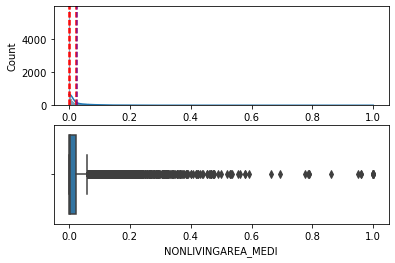

count    11351.000000
mean         0.026101
std          0.064820
min          0.000000
25%          0.000000
50%          0.002200
75%          0.024400
max          1.000000
Name: NONLIVINGAREA_MEDI, dtype: float64

lower whisker: 0.0
upper whisker: 0.0609
outlier: [0.7892, 0.0925, 0.0627, 0.0788, 0.0916, 0.1457, 0.0694, 0.0985, 0.3256, 0.0726, 0.083, 0.2628, 0.2362, 0.1429, 0.0615, 0.0717, 0.1782, 0.0911, 0.1281, 0.1068, 0.0887, 0.0976, 0.064, 0.0942, 0.1376, 0.1366, 0.138, 0.1121, 0.1546, 0.0623, 0.5277, 0.3869, 0.0709, 0.109, 0.0786, 0.2668, 0.0714, 0.106, 0.066, 0.0771, 0.0707, 0.1189, 0.0661, 0.0667, 0.0699, 0.2299, 0.2568, 0.7872, 0.116, 0.1892, 0.2857, 0.0738, 0.4248, 0.0864, 0.0768, 0.1056, 0.1467, 0.1278, 0.0976, 0.3892, 0.0801, 0.0731, 0.0763, 0.0654, 0.0688, 0.1535, 0.0791, 0.0695, 0.0969, 0.1111, 0.0776, 0.0711, 0.068, 0.4389, 0.1656, 0.0677, 0.088, 0.1593, 0.0825, 0.1578, 0.1013, 0.2044, 0.1964, 0.1624, 0.3419, 0.1059, 0.1254, 0.0814, 0.1677, 0.3196, 0.2165, 0.2251, 0.09

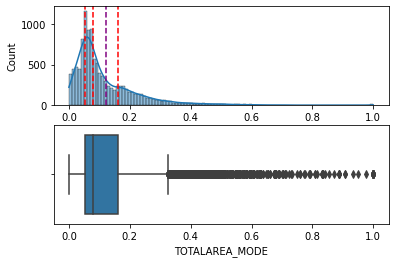

count    11351.000000
mean         0.121284
std          0.119014
min          0.000000
25%          0.051300
50%          0.078500
75%          0.160400
max          1.000000
Name: TOTALAREA_MODE, dtype: float64

lower whisker: 0.0
upper whisker: 0.324
outlier: [0.7334, 0.4064, 0.3288, 0.6093, 0.4822, 0.3957, 0.3326, 0.4339, 0.3555, 0.3651, 0.5119, 0.3385, 0.3402, 0.4516, 0.4794, 0.4822, 0.446, 0.3429, 0.3495, 0.3799, 0.3257, 0.377, 0.4270000000000001, 1.0, 0.4026, 0.3565, 0.3926, 0.4868, 0.3595, 0.3319, 0.4023, 0.5694, 0.3276, 0.358, 0.3339, 0.6741, 0.6273, 0.3301, 0.5978, 0.3306, 0.4396, 0.7283, 0.6057, 0.3787, 0.5498, 0.4402, 0.4002, 0.4922, 0.4904, 0.4077, 0.3892, 0.4435, 0.4057, 1.0, 0.4956, 0.5808, 0.329, 0.6785, 0.5304, 0.3562, 0.3353, 0.8308, 0.3463, 0.4476, 0.3463, 0.3355, 0.3725, 0.3911, 0.5037, 0.3997, 0.3846, 0.3753, 0.5086, 0.3336, 0.4936, 0.574, 0.6005, 0.4397, 0.6995, 0.3369, 0.4214, 0.5974, 0.3439, 0.4801, 0.7135, 0.5329999999999999, 0.3628, 0.377, 0.3319, 0.5393, 0.36

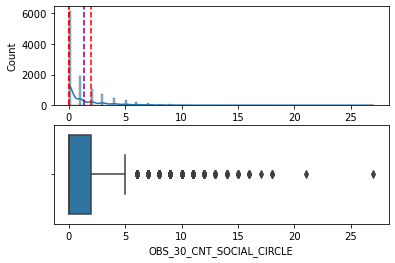

count    11351.000000
mean         1.342172
std          2.210288
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         27.000000
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64

lower whisker: 0.0
upper whisker: 5.0
outlier: [6.0, 6.0, 9.0, 9.0, 8.0, 9.0, 6.0, 6.0, 7.0, 6.0, 7.0, 8.0, 6.0, 8.0, 9.0, 9.0, 8.0, 8.0, 6.0, 6.0, 8.0, 6.0, 14.0, 6.0, 8.0, 7.0, 6.0, 13.0, 8.0, 7.0, 6.0, 6.0, 10.0, 7.0, 7.0, 6.0, 11.0, 9.0, 15.0, 12.0, 7.0, 8.0, 8.0, 6.0, 13.0, 9.0, 7.0, 9.0, 6.0, 10.0, 8.0, 11.0, 6.0, 7.0, 6.0, 7.0, 8.0, 6.0, 10.0, 8.0, 8.0, 12.0, 6.0, 6.0, 7.0, 8.0, 9.0, 7.0, 11.0, 11.0, 9.0, 10.0, 6.0, 6.0, 7.0, 8.0, 10.0, 9.0, 7.0, 7.0, 9.0, 9.0, 6.0, 13.0, 7.0, 6.0, 8.0, 8.0, 6.0, 6.0, 8.0, 7.0, 9.0, 6.0, 10.0, 9.0, 8.0, 8.0, 7.0, 7.0, 6.0, 8.0, 7.0, 6.0, 8.0, 7.0, 8.0, 8.0, 8.0, 6.0, 14.0, 6.0, 11.0, 7.0, 6.0, 8.0, 6.0, 7.0, 10.0, 10.0, 7.0, 7.0, 6.0, 8.0, 9.0, 9.0, 6.0, 15.0, 7.0, 7.0, 7.0, 12.0, 7.0, 9.0, 10.0, 7.0, 11.0, 7.0, 6.0, 6.0, 6.0

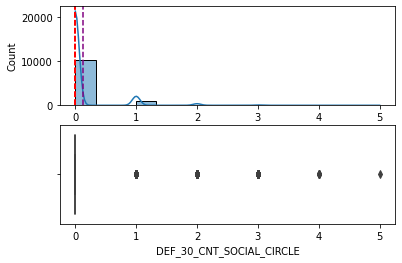

count    11351.000000
mean         0.127654
std          0.410440
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: float64

lower whisker: 0.0
upper whisker: 0.0
outlier: [1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 3.0, 1.0, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0

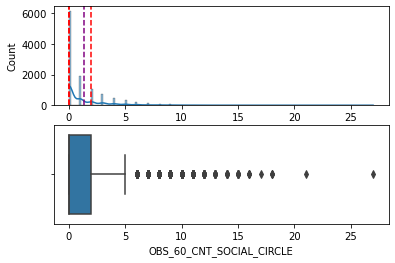

count    11351.000000
mean         1.326932
std          2.193618
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         27.000000
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: float64

lower whisker: 0.0
upper whisker: 5.0
outlier: [6.0, 6.0, 9.0, 9.0, 8.0, 9.0, 6.0, 6.0, 7.0, 6.0, 7.0, 8.0, 6.0, 8.0, 9.0, 9.0, 8.0, 8.0, 6.0, 6.0, 8.0, 6.0, 14.0, 6.0, 8.0, 7.0, 6.0, 13.0, 8.0, 7.0, 6.0, 6.0, 9.0, 7.0, 7.0, 10.0, 9.0, 15.0, 12.0, 7.0, 8.0, 8.0, 13.0, 9.0, 7.0, 9.0, 6.0, 10.0, 8.0, 11.0, 6.0, 7.0, 6.0, 7.0, 8.0, 10.0, 7.0, 8.0, 12.0, 6.0, 6.0, 7.0, 8.0, 9.0, 7.0, 11.0, 11.0, 9.0, 10.0, 6.0, 6.0, 7.0, 8.0, 10.0, 9.0, 7.0, 7.0, 9.0, 9.0, 6.0, 13.0, 7.0, 6.0, 8.0, 7.0, 6.0, 6.0, 8.0, 7.0, 9.0, 6.0, 10.0, 9.0, 8.0, 7.0, 7.0, 7.0, 6.0, 8.0, 7.0, 6.0, 8.0, 7.0, 8.0, 8.0, 7.0, 6.0, 14.0, 6.0, 11.0, 7.0, 8.0, 6.0, 7.0, 10.0, 10.0, 7.0, 7.0, 6.0, 8.0, 9.0, 9.0, 6.0, 15.0, 7.0, 7.0, 7.0, 12.0, 7.0, 9.0, 10.0, 7.0, 11.0, 7.0, 6.0, 6.0, 6.0, 6.0, 6.0, 8.0, 6.0,

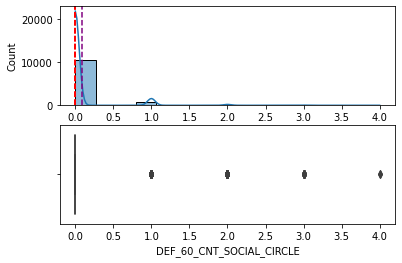

count    11351.000000
mean         0.088362
std          0.329246
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: DEF_60_CNT_SOCIAL_CIRCLE, dtype: float64

lower whisker: 0.0
upper whisker: 0.0
outlier: [1.0, 2.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0

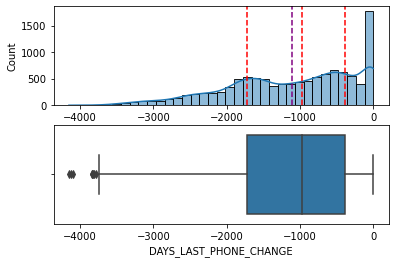

count    11351.000000
mean     -1105.098053
std        867.609052
min      -4153.000000
25%      -1729.000000
50%       -969.000000
75%       -380.500000
max          0.000000
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

lower whisker: -3747.0
upper whisker: 0.0
outlier: [-3841.0, -4153.0, -4131.0, -4092.0, -3841.0, -3807.0, -3789.0, -3824.0]
outlier count: 8
Data skewed dengan nilai p-value 1.3398541000355323e-112 dan skew -0.5535132943159883
80. FLAG_DOCUMENT_2



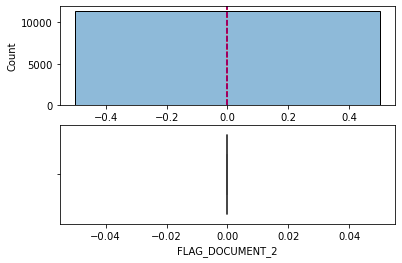

count    11351.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: FLAG_DOCUMENT_2, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: []
outlier count: 0
Data tidak skewed
81. FLAG_DOCUMENT_3



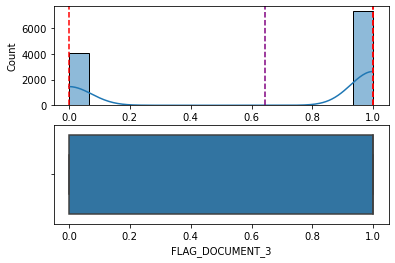

count    11351.000000
mean         0.644084
std          0.478811
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: FLAG_DOCUMENT_3, dtype: float64

lower whisker: 0
upper whisker: 1
outlier: []
outlier count: 0
Data skewed dengan nilai p-value 4.194873006539757e-130 dan skew -0.6018682995698913
82. FLAG_DOCUMENT_4



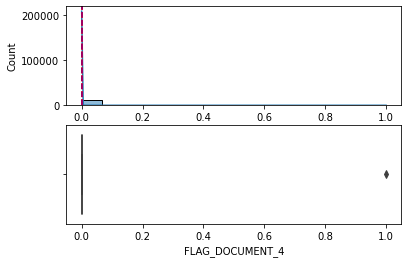

count    11351.000000
mean         0.000088
std          0.009386
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG_DOCUMENT_4, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1]
outlier count: 1
Data skewed dengan nilai p-value 0.0 dan skew 106.52699229822329
83. FLAG_DOCUMENT_5



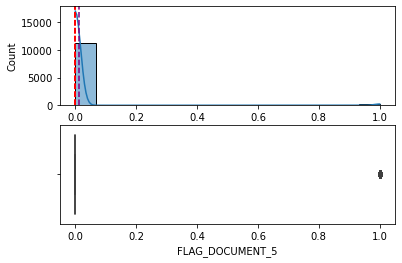

count    11351.000000
mean         0.013038
std          0.113444
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG_DOCUMENT_5, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
outlier count: 148
Data skewed dengan nilai p-value 0.0 dan skew 8.58540370006369
84. FLAG_DOCUMENT_6



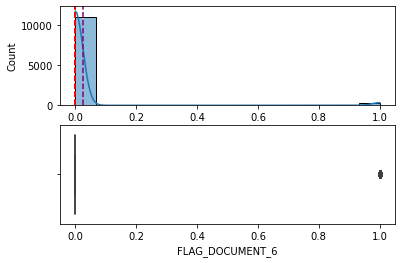

count    11351.000000
mean         0.026958
std          0.161968
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG_DOCUMENT_6, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

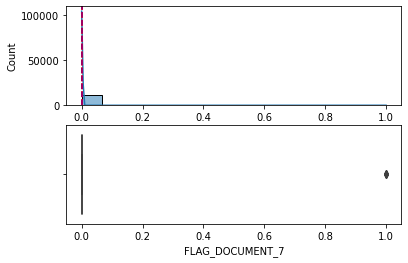

count    11351.000000
mean         0.000352
std          0.018770
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG_DOCUMENT_7, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1]
outlier count: 4
Data skewed dengan nilai p-value 0.0 dan skew 53.24237365591511
86. FLAG_DOCUMENT_8



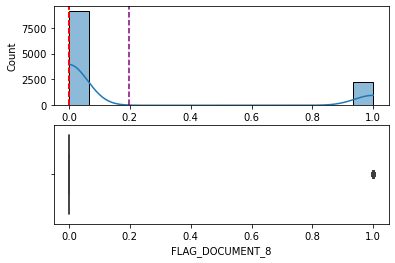

count    11351.000000
mean         0.196282
std          0.397202
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG_DOCUMENT_8, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

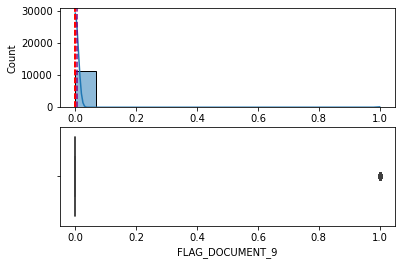

count    11351.000000
mean         0.004405
std          0.066226
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG_DOCUMENT_9, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
outlier count: 50
Data skewed dengan nilai p-value 0.0 dan skew 14.967445486362143
88. FLAG_DOCUMENT_10



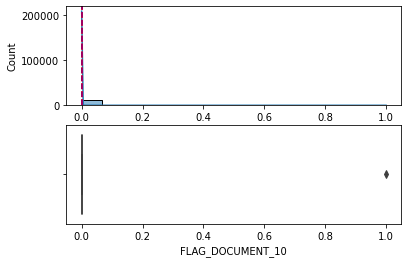

count    11351.000000
mean         0.000088
std          0.009386
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG_DOCUMENT_10, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1]
outlier count: 1
Data skewed dengan nilai p-value 0.0 dan skew 106.52699229822329
89. FLAG_DOCUMENT_11



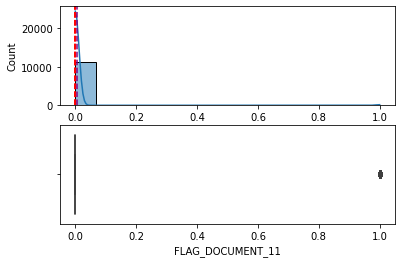

count    11351.000000
mean         0.006343
std          0.079394
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG_DOCUMENT_11, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
outlier count: 72
Data skewed dengan nilai p-value 0.0 dan skew 12.436203653945926
90. FLAG_DOCUMENT_12



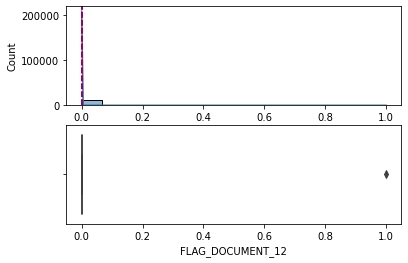

count    11351.000000
mean         0.000088
std          0.009386
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG_DOCUMENT_12, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1]
outlier count: 1
Data skewed dengan nilai p-value 0.0 dan skew 106.52699229822326
91. FLAG_DOCUMENT_13



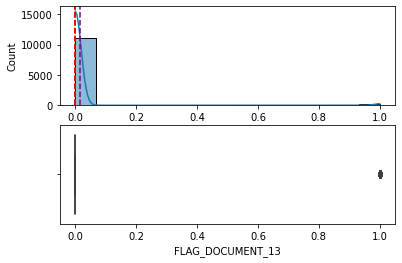

count    11351.000000
mean         0.015593
std          0.123901
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG_DOCUMENT_13, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
outlier count: 177
Data skewed dengan nilai p-value 0.0 dan skew 7.819576960838719
92. FLAG_DOCUMENT_14



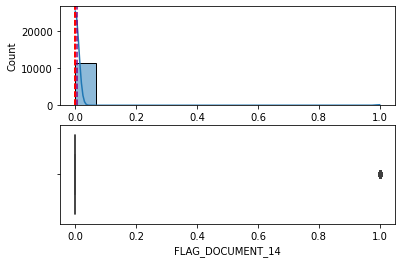

count    11351.000000
mean         0.005903
std          0.076604
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG_DOCUMENT_14, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
outlier count: 67
Data skewed dengan nilai p-value 0.0 dan skew 12.900536735288853
93. FLAG_DOCUMENT_15



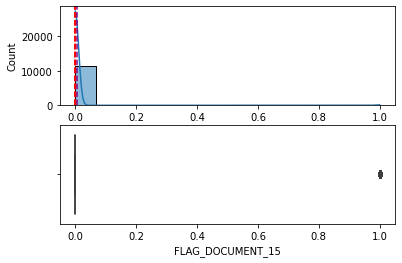

count    11351.000000
mean         0.005110
std          0.071302
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG_DOCUMENT_15, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
outlier count: 58
Data skewed dengan nilai p-value 0.0 dan skew 13.882075942618714
94. FLAG_DOCUMENT_16



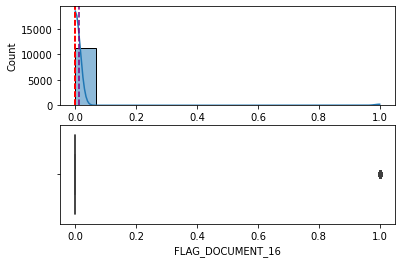

count    11351.000000
mean         0.011012
std          0.104364
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG_DOCUMENT_16, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
outlier count: 125
Data skewed dengan nilai p-value 0.0 dan skew 9.371186417177437
95. FLAG_DOCUMENT_17



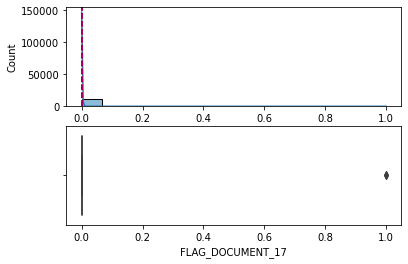

count    11351.000000
mean         0.000176
std          0.013273
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG_DOCUMENT_17, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1]
outlier count: 2
Data skewed dengan nilai p-value 0.0 dan skew 75.31600212588945
96. FLAG_DOCUMENT_18



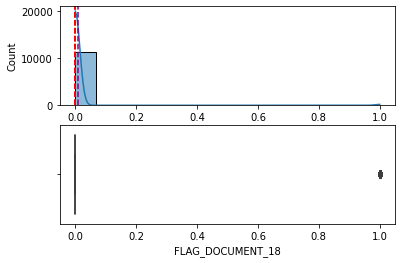

count    11351.000000
mean         0.009515
std          0.097082
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG_DOCUMENT_18, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
outlier count: 108
Data skewed dengan nilai p-value 0.0 dan skew 10.105021416548517
97. FLAG_DOCUMENT_19



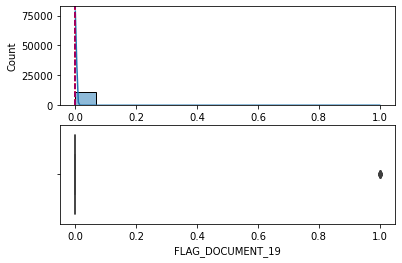

count    11351.000000
mean         0.000617
std          0.024827
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG_DOCUMENT_19, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1, 1, 1, 1]
outlier count: 7
Data skewed dengan nilai p-value 0.0 dan skew 40.231480778585805
98. FLAG_DOCUMENT_20



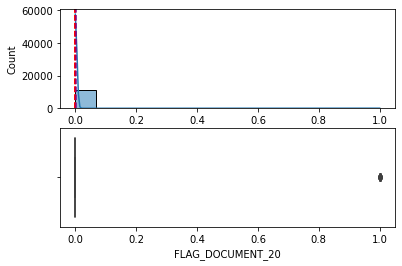

count    11351.000000
mean         0.001145
std          0.033824
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG_DOCUMENT_20, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
outlier count: 13
Data skewed dengan nilai p-value 0.0 dan skew 29.498389663514637
99. FLAG_DOCUMENT_21



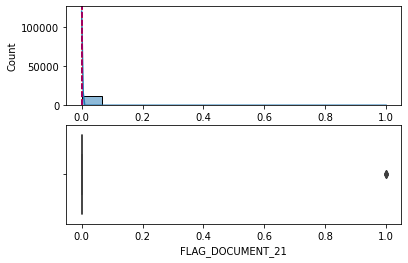

count    11351.000000
mean         0.000264
std          0.016256
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: FLAG_DOCUMENT_21, dtype: float64

lower whisker: 0
upper whisker: 0
outlier: [1, 1, 1]
outlier count: 3
Data skewed dengan nilai p-value 0.0 dan skew 61.48712817354889
100. AMT_REQ_CREDIT_BUREAU_HOUR



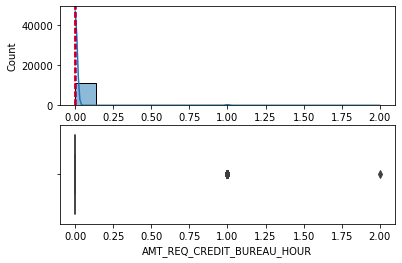

count    11351.000000
mean         0.006695
std          0.082628
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: AMT_REQ_CREDIT_BUREAU_HOUR, dtype: float64

lower whisker: 0.0
upper whisker: 0.0
outlier: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
outlier count: 75
Data skewed dengan nilai p-value 0.0 dan skew 12.563522672841135
101. AMT_REQ_CREDIT_BUREAU_DAY



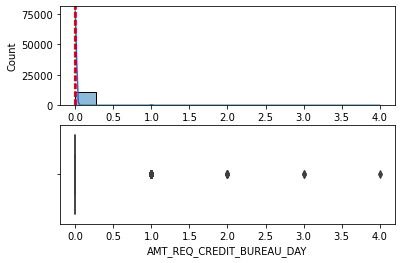

count    11351.000000
mean         0.007136
std          0.100405
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: float64

lower whisker: 0.0
upper whisker: 0.0
outlier: [1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0]
outlier count: 69
Data skewed dengan nilai p-value 0.0 dan skew 18.849667434890755
102. AMT_REQ_CREDIT_BUREAU_WEEK



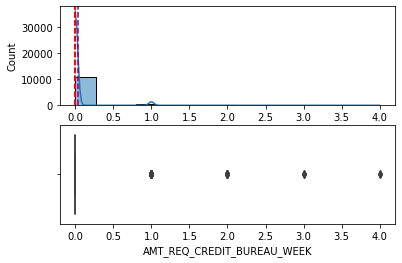

count    11351.000000
mean         0.039292
std          0.207879
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: AMT_REQ_CREDIT_BUREAU_WEEK, dtype: float64

lower whisker: 0.0
upper whisker: 0.0
outlier: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

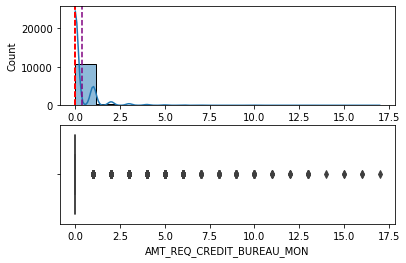

count    11351.000000
mean         0.368602
std          1.063689
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         17.000000
Name: AMT_REQ_CREDIT_BUREAU_MON, dtype: float64

lower whisker: 0.0
upper whisker: 0.0
outlier: [1.0, 1.0, 6.0, 1.0, 1.0, 1.0, 1.0, 4.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0, 11.0, 2.0, 4.0, 2.0, 1.0, 4.0, 1.0, 3.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 4.0, 1.0, 3.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 3.0, 3.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 9.0, 1.0, 2.0, 1.0, 1.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

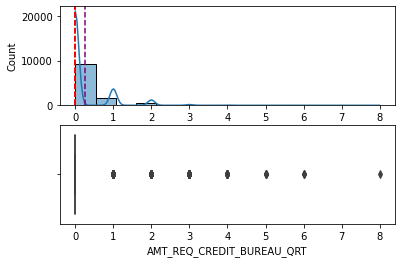

count    11351.000000
mean         0.259272
std          0.596758
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: float64

lower whisker: 0.0
upper whisker: 0.0
outlier: [1.0, 1.0, 4.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 3.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 3.0, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 3.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0, 2.0, 1.0, 1.0, 1.0, 6.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

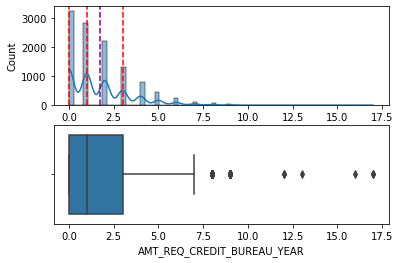

count    11351.000000
mean         1.762840
std          1.776141
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         17.000000
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: float64

lower whisker: 0.0
upper whisker: 7.0
outlier: [8.0, 8.0, 8.0, 8.0, 12.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 16.0, 8.0, 9.0, 8.0, 8.0, 8.0, 9.0, 9.0, 8.0, 9.0, 9.0, 8.0, 8.0, 12.0, 9.0, 9.0, 8.0, 8.0, 9.0, 8.0, 9.0, 8.0, 17.0, 8.0, 9.0, 9.0, 9.0, 9.0, 8.0, 9.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 8.0, 9.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 8.0, 9.0, 8.0, 8.0, 9.0, 9.0, 8.0, 8.0, 8.0, 8.0, 9.0, 8.0, 8.0, 9.0, 8.0, 13.0, 8.0, 17.0, 9.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 8.0, 9.0, 8.0, 9.0, 9.0, 9.0, 9.0, 8.0, 8.0, 8.0, 8.0]
outlier count: 108
Data skewed dengan nilai p-value 0.0 dan skew 1.3664151247007015


In [12]:
a = 1
for x in train_num.columns:
    print(f"{a}. {x}")
    print()
    
    #histogram dan boxplot
    fig, axs = plt.subplots(2,1)
    sns.histplot(data = train_num, x=x, kde=True, ax=axs[0])
    axs[0].axvline(np.percentile(train_num[x], 25), color='red', linestyle='--')
    axs[0].axvline(np.percentile(train_num[x], 50), color='red', linestyle='--')
    axs[0].axvline(np.percentile(train_num[x], 75), color='red', linestyle='--')
    axs[0].axvline(np.mean(train_num[x]), color='purple', linestyle='--')

    sns.boxplot(data = train_num, x=x, ax=axs[1])

    plt.show()
    
    #metode describe
    print(train_num[x].describe())
    print()
    
    #lower_whisker, upper_whisker, outlier, outlier_count
    def whisk(x):
        q1 = np.nanpercentile(x, 25)
        q3 = np.nanpercentile(x, 75)
        iqr = q3 - q1
        lower_fence = q1 - 1.5*iqr
        upper_fence = q3 + 1.5*iqr
        
        #identifikasi nilai upper whisker dan lower whisker
        non_outlier = []
        for num in x:
            if num >= lower_fence:
                if num <= upper_fence:
                    non_outlier.append(num)
                    
        lower_whisker = np.min(non_outlier)
        upper_whisker = np.max(non_outlier)
        
        #identifikasi outlier dan outlier_count
        outlier = []
        for num in x:
            if num < lower_fence:
                outlier.append(num)
            if num > upper_fence:
                outlier.append(num)
                
        outlier_count = len(outlier)
        
        print(f"lower whisker: {lower_whisker}")
        print(f"upper whisker: {upper_whisker}")
        print(f"outlier: {outlier}")
        print(f"outlier count: {outlier_count}")
    
    whisk(train_num[x])
    
    #hitung skew
    skw= skew(train_num[x])
    stat, pvalue = skewtest(train_num[x])
    if pvalue < 0.05:
        print(f"Data skewed dengan nilai p-value {pvalue} dan skew {skw}")
    else:
        print("Data tidak skewed")
    
    print('='*100)
    a += 1

1. NAME_CONTRACT_TYPE



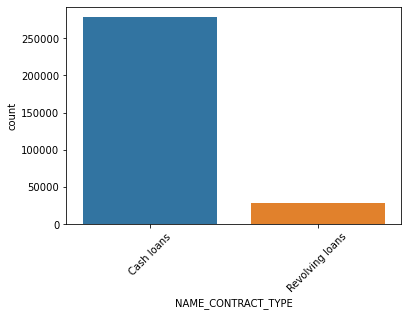


unique values: ['Cash loans' 'Revolving loans']
unique value counts: 2

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64
Cash loans         0.904787
Revolving loans    0.095213
Name: NAME_CONTRACT_TYPE, dtype: float64
****************************************************************************************************
2. CODE_GENDER



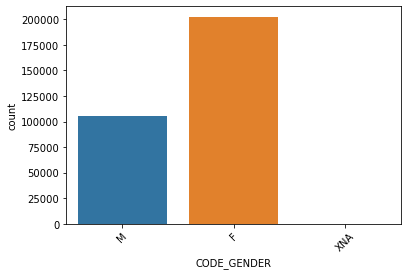


unique values: ['M' 'F' 'XNA']
unique value counts: 3

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64
F      0.658344
M      0.341643
XNA    0.000013
Name: CODE_GENDER, dtype: float64
****************************************************************************************************
3. FLAG_OWN_CAR



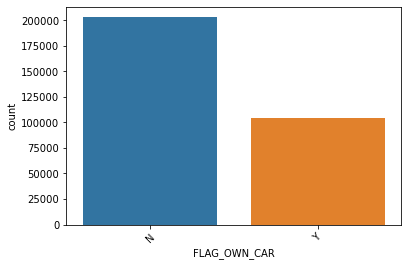


unique values: ['N' 'Y']
unique value counts: 2

N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64
N    0.659892
Y    0.340108
Name: FLAG_OWN_CAR, dtype: float64
****************************************************************************************************
4. FLAG_OWN_REALTY



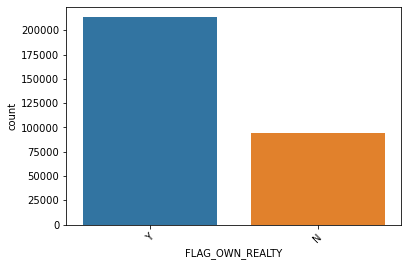


unique values: ['Y' 'N']
unique value counts: 2

Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64
Y    0.693673
N    0.306327
Name: FLAG_OWN_REALTY, dtype: float64
****************************************************************************************************
5. NAME_TYPE_SUITE



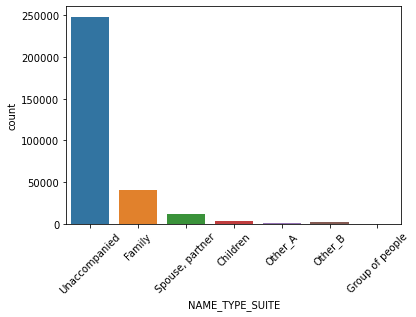


unique values: ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
unique value counts: 8

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64
Unaccompanied      0.811596
Family             0.131112
Spouse, partner    0.037130
Children           0.010669
Other_B            0.005780
Other_A            0.002828
Group of people    0.000885
Name: NAME_TYPE_SUITE, dtype: float64
****************************************************************************************************
6. NAME_INCOME_TYPE



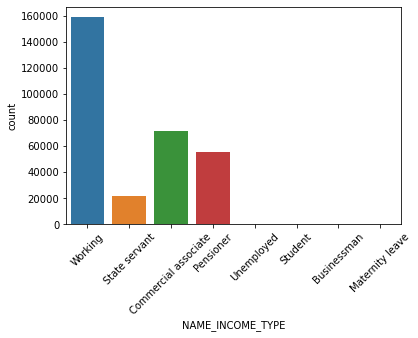


unique values: ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
unique value counts: 8

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64
Working                 0.516320
Commercial associate    0.232892
Pensioner               0.180033
State servant           0.070576
Unemployed              0.000072
Student                 0.000059
Businessman             0.000033
Maternity leave         0.000016
Name: NAME_INCOME_TYPE, dtype: float64
****************************************************************************************************
7. NAME_EDUCATION_TYPE



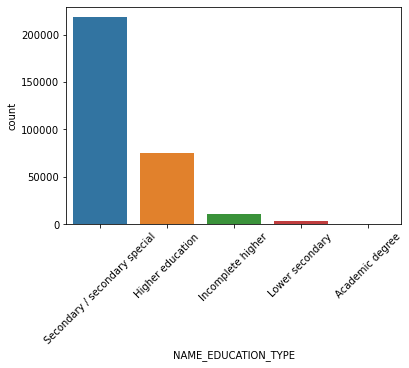


unique values: ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
unique value counts: 5

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64
Secondary / secondary special    0.710189
Higher education                 0.243448
Incomplete higher                0.033420
Lower secondary                  0.012409
Academic degree                  0.000533
Name: NAME_EDUCATION_TYPE, dtype: float64
****************************************************************************************************
8. NAME_FAMILY_STATUS



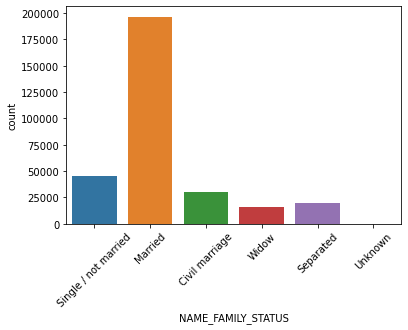


unique values: ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
unique value counts: 6

Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64
Married                 0.638780
Single / not married    0.147780
Civil marriage          0.096826
Separated               0.064290
Widow                   0.052317
Unknown                 0.000007
Name: NAME_FAMILY_STATUS, dtype: float64
****************************************************************************************************
9. NAME_HOUSING_TYPE



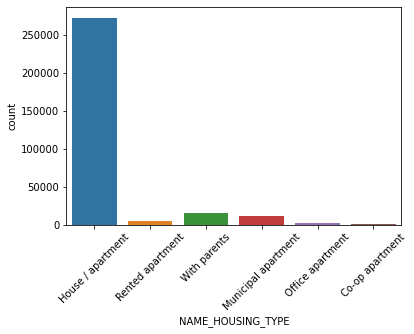


unique values: ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
unique value counts: 6

House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: NAME_HOUSING_TYPE, dtype: int64
House / apartment      0.887344
With parents           0.048258
Municipal apartment    0.036366
Rented apartment       0.015873
Office apartment       0.008510
Co-op apartment        0.003649
Name: NAME_HOUSING_TYPE, dtype: float64
****************************************************************************************************
10. OCCUPATION_TYPE



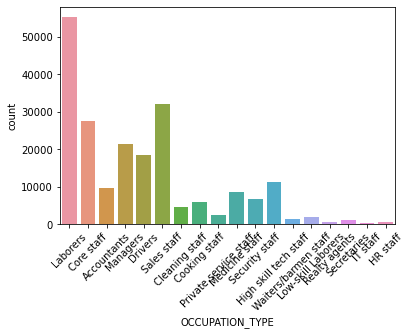


unique values: ['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT staff' 'HR staff']
unique value counts: 19

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64
Laborers                 0.261396
Sales staff              0.152056
Cor

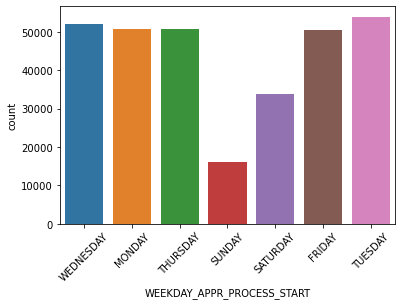


unique values: ['WEDNESDAY' 'MONDAY' 'THURSDAY' 'SUNDAY' 'SATURDAY' 'FRIDAY' 'TUESDAY']
unique value counts: 7

TUESDAY      53901
WEDNESDAY    51934
MONDAY       50714
THURSDAY     50591
FRIDAY       50338
SATURDAY     33852
SUNDAY       16181
Name: WEEKDAY_APPR_PROCESS_START, dtype: int64
TUESDAY      0.175282
WEDNESDAY    0.168885
MONDAY       0.164918
THURSDAY     0.164518
FRIDAY       0.163695
SATURDAY     0.110084
SUNDAY       0.052619
Name: WEEKDAY_APPR_PROCESS_START, dtype: float64
****************************************************************************************************
12. ORGANIZATION_TYPE



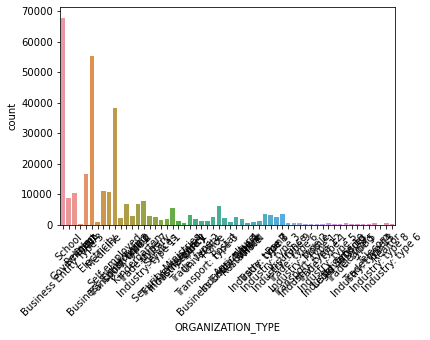


unique values: ['Business Entity Type 3' 'School' 'Government' 'Religion' 'Other' 'XNA'
 'Electricity' 'Medicine' 'Business Entity Type 2' 'Self-employed'
 'Transport: type 2' 'Construction' 'Housing' 'Kindergarten'
 'Trade: type 7' 'Industry: type 11' 'Military' 'Services'
 'Security Ministries' 'Transport: type 4' 'Industry: type 1' 'Emergency'
 'Security' 'Trade: type 2' 'University' 'Transport: type 3' 'Police'
 'Business Entity Type 1' 'Postal' 'Industry: type 4' 'Agriculture'
 'Restaurant' 'Culture' 'Hotel' 'Industry: type 7' 'Trade: type 3'
 'Industry: type 3' 'Bank' 'Industry: type 9' 'Insurance' 'Trade: type 6'
 'Industry: type 2' 'Transport: type 1' 'Industry: type 12' 'Mobile'
 'Trade: type 1' 'Industry: type 5' 'Industry: type 10' 'Legal Services'
 'Advertising' 'Trade: type 5' 'Cleaning' 'Industry: type 13'
 'Trade: type 4' 'Telecom' 'Industry: type 8' 'Realtor' 'Industry: type 6']
unique value counts: 58

Business Entity Type 3    67992
XNA                       55374
Se

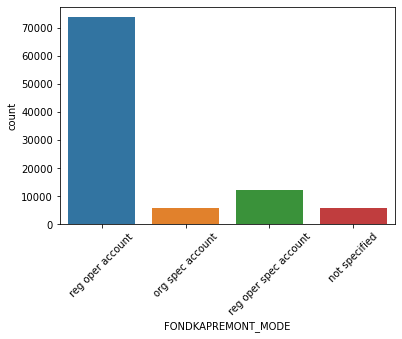


unique values: ['reg oper account' nan 'org spec account' 'reg oper spec account'
 'not specified']
unique value counts: 5

reg oper account         73830
reg oper spec account    12080
not specified             5687
org spec account          5619
Name: FONDKAPREMONT_MODE, dtype: int64
reg oper account         0.759443
reg oper spec account    0.124259
not specified            0.058499
org spec account         0.057799
Name: FONDKAPREMONT_MODE, dtype: float64
****************************************************************************************************
14. HOUSETYPE_MODE



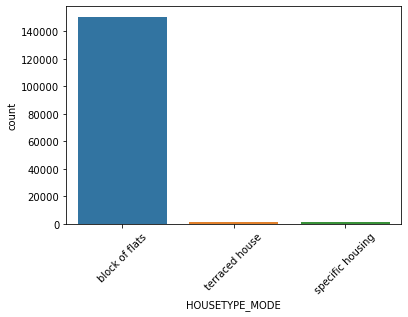


unique values: ['block of flats' nan 'terraced house' 'specific housing']
unique value counts: 4

block of flats      150503
specific housing      1499
terraced house        1212
Name: HOUSETYPE_MODE, dtype: int64
block of flats      0.982306
specific housing    0.009784
terraced house      0.007911
Name: HOUSETYPE_MODE, dtype: float64
****************************************************************************************************
15. WALLSMATERIAL_MODE



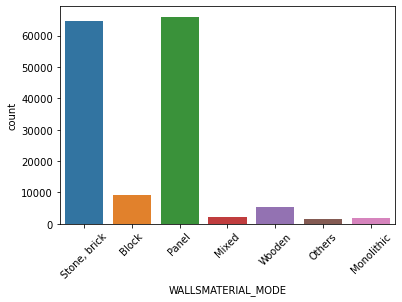


unique values: ['Stone, brick' 'Block' nan 'Panel' 'Mixed' 'Wooden' 'Others' 'Monolithic']
unique value counts: 8

Panel           66040
Stone, brick    64815
Block            9253
Wooden           5362
Mixed            2296
Monolithic       1779
Others           1625
Name: WALLSMATERIAL_MODE, dtype: int64
Panel           0.436859
Stone, brick    0.428756
Block           0.061209
Wooden          0.035470
Mixed           0.015188
Monolithic      0.011768
Others          0.010749
Name: WALLSMATERIAL_MODE, dtype: float64
****************************************************************************************************
16. EMERGENCYSTATE_MODE



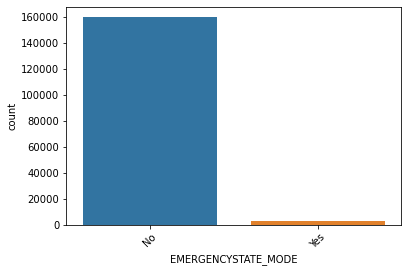


unique values: ['No' nan 'Yes']
unique value counts: 3

No     159428
Yes      2328
Name: EMERGENCYSTATE_MODE, dtype: int64
No     0.985608
Yes    0.014392
Name: EMERGENCYSTATE_MODE, dtype: float64
****************************************************************************************************


In [13]:
a = 1
for col in train_obj.columns:
    print(f"{a}. {col}")
    print()
    
    #countplot
    sns.countplot(data=train_obj, x=col)
    plt.xticks(rotation=45)
    plt.show()
    print()
    
    #kategori unik dan daftar kategori unik
    print(f"unique values: {train_obj[col].unique()}")
    print(f"unique value counts: {len(train_obj[col].unique())}")
    print()
    
    #value count
    print(train_obj[col].value_counts())
    print(train_obj[col].value_counts(normalize=True))
    
    print('*'*100)
    a+=1

In [14]:
# a = 1
# var = []
# for x in train_num.columns:
#     for y in train_num.columns:
#         if x != y:
#             if [y, x] not in var:
#                 print(f"{a}. regplot antara {x} dan {y}")
                
#                 sns.regplot(data = train_num, 
#                             x = x, 
#                             y = y, 
#                             scatter_kws = {'color':'blue'},
#                             line_kws = {'color':'red'})
#                 plt.show()
                
#                 if (normaltest(train_num[x])[1] > 0.05) & (normaltest(train_num[y])[1] > 0.05):
#                     print(pearsonr(train_num[x], train_num[y]))
#                 else:
#                     print(spearmanr(train_num[x], train_num[y]))


                
#                 var.append([x, y])
                
#                 print('*'*100)
                
#                 a += 1

Hasil uji normaltest banyak variabel yang tidak normal sehingga banyak uji test normal menggunakan Spearman

## Drop Data

In [15]:
def missing_values_table(df):
        # jumlah missing value
        mis_val = df.isnull().sum()
        
        # persentase pada missing value
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # membuat tabel hasil
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # ganti nama kolom
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # mengurutkan tabel persentase missing value
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # print beberapa summary hasil missing value
        print ("Dataframe ada " + str(df.shape[1]) + " kolom.\n"      
            "Ada " + str(mis_val_table_ren_columns.shape[0]) +
              " kolom terdapat missing value.")
        
        
        # Return df dengan info missing value
        return mis_val_table_ren_columns

In [16]:
missing_values_table(train).head(10)

Dataframe ada 122 kolom.
Ada 67 kolom terdapat missing value.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [17]:
missing_values_table(test).head(10)

Dataframe ada 121 kolom.
Ada 64 kolom terdapat missing value.


,Missing Values,% of Total Values
COMMONAREA_MODE,33495,68.7
COMMONAREA_MEDI,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [18]:
missing_fractions_train = train.isnull().mean().sort_values(ascending=False)
missing_fractions_train.head(10)

COMMONAREA_MEDI             0.698723
COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
NONLIVINGAPARTMENTS_MEDI    0.694330
FONDKAPREMONT_MODE          0.683862
LIVINGAPARTMENTS_MODE       0.683550
LIVINGAPARTMENTS_AVG        0.683550
LIVINGAPARTMENTS_MEDI       0.683550
dtype: float64

In [19]:
missing_fractions_test = test.isnull().mean().sort_values(ascending=False)
missing_fractions_test.head(10)

COMMONAREA_AVG              0.687161
COMMONAREA_MODE             0.687161
COMMONAREA_MEDI             0.687161
NONLIVINGAPARTMENTS_AVG     0.684125
NONLIVINGAPARTMENTS_MODE    0.684125
NONLIVINGAPARTMENTS_MEDI    0.684125
FONDKAPREMONT_MODE          0.672842
LIVINGAPARTMENTS_AVG        0.672493
LIVINGAPARTMENTS_MODE       0.672493
LIVINGAPARTMENTS_MEDI       0.672493
dtype: float64

Text(0, 0.5, 'Feature count')

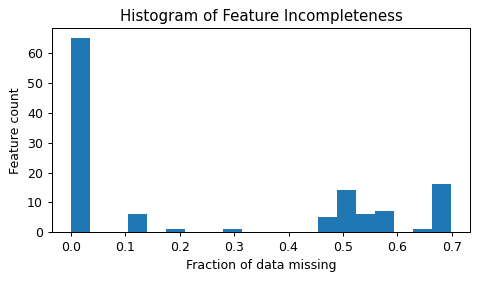

In [20]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions_train.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

Text(0, 0.5, 'Feature count')

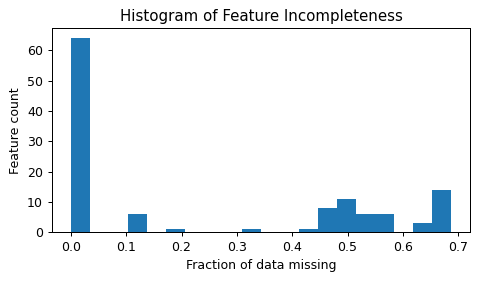

In [21]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions_test.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

In [22]:
drop_list_train = sorted(list(missing_fractions_train[missing_fractions_train > 0.3].index))
print(drop_list_train)
print("\n\n Drop Features: ", len(drop_list_train))

['APARTMENTS_AVG', 'APARTMENTS_MEDI', 'APARTMENTS_MODE', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE', 'COMMONAREA_AVG', 'COMMONAREA_MEDI', 'COMMONAREA_MODE', 'ELEVATORS_AVG', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'EMERGENCYSTATE_MODE', 'ENTRANCES_AVG', 'ENTRANCES_MEDI', 'ENTRANCES_MODE', 'EXT_SOURCE_1', 'FLOORSMAX_AVG', 'FLOORSMAX_MEDI', 'FLOORSMAX_MODE', 'FLOORSMIN_AVG', 'FLOORSMIN_MEDI', 'FLOORSMIN_MODE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'LANDAREA_AVG', 'LANDAREA_MEDI', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_AVG', 'LIVINGAREA_MEDI', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE', 'OCCUPATION_TYPE', 'OWN_CAR_AGE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_AVG', 'YEARS_BUILD_MEDI'

In [23]:
drop_list_test = sorted(list(missing_fractions_test[missing_fractions_test > 0.3].index))
print(drop_list_test)
print("\n\n Drop Features: ", len(drop_list_test))

['APARTMENTS_AVG', 'APARTMENTS_MEDI', 'APARTMENTS_MODE', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE', 'COMMONAREA_AVG', 'COMMONAREA_MEDI', 'COMMONAREA_MODE', 'ELEVATORS_AVG', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'EMERGENCYSTATE_MODE', 'ENTRANCES_AVG', 'ENTRANCES_MEDI', 'ENTRANCES_MODE', 'EXT_SOURCE_1', 'FLOORSMAX_AVG', 'FLOORSMAX_MEDI', 'FLOORSMAX_MODE', 'FLOORSMIN_AVG', 'FLOORSMIN_MEDI', 'FLOORSMIN_MODE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'LANDAREA_AVG', 'LANDAREA_MEDI', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_AVG', 'LIVINGAREA_MEDI', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE', 'OCCUPATION_TYPE', 'OWN_CAR_AGE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_AVG', 'YEARS_BUILD_MEDI'

In [24]:
# Drop these features for data train
train.drop(labels=drop_list_train, axis=1, inplace=True)

In [25]:
# Drop these features for data test
test.drop(labels=drop_list_test, axis=1, inplace=True)

In [26]:
train.shape

(307511, 72)

In [27]:
test.shape

(48744, 71)

## Handling Missing Value and Cleaning Data

In [28]:
missing_value_train = missing_values_table(train)
missing_value_train.head(20)

Dataframe ada 72 kolom.
Ada 17 kolom terdapat missing value.


,Missing Values,% of Total Values
EXT_SOURCE_3,60965,19.8
AMT_REQ_CREDIT_BUREAU_YEAR,41519,13.5
AMT_REQ_CREDIT_BUREAU_QRT,41519,13.5
AMT_REQ_CREDIT_BUREAU_MON,41519,13.5
AMT_REQ_CREDIT_BUREAU_WEEK,41519,13.5
AMT_REQ_CREDIT_BUREAU_DAY,41519,13.5
AMT_REQ_CREDIT_BUREAU_HOUR,41519,13.5
NAME_TYPE_SUITE,1292,0.4
DEF_60_CNT_SOCIAL_CIRCLE,1021,0.3
OBS_60_CNT_SOCIAL_CIRCLE,1021,0.3


In [29]:
missing_value_test = missing_values_table(test)
missing_value_test.head(20)

Dataframe ada 71 kolom.
Ada 14 kolom terdapat missing value.


,Missing Values,% of Total Values
EXT_SOURCE_3,8668,17.8
AMT_REQ_CREDIT_BUREAU_HOUR,6049,12.4
AMT_REQ_CREDIT_BUREAU_DAY,6049,12.4
AMT_REQ_CREDIT_BUREAU_WEEK,6049,12.4
AMT_REQ_CREDIT_BUREAU_MON,6049,12.4
AMT_REQ_CREDIT_BUREAU_QRT,6049,12.4
AMT_REQ_CREDIT_BUREAU_YEAR,6049,12.4
NAME_TYPE_SUITE,911,1.9
OBS_30_CNT_SOCIAL_CIRCLE,29,0.1
DEF_30_CNT_SOCIAL_CIRCLE,29,0.1


### SimpleImputer

Seharusnya menggunakan KNNImputer jika missing value berada di persentase (<= 10% - 30%). Tetapi ketika dilakukan imputer dengan KNN tidak bisa dan notebook menjadi hang. Sehingga semua data numerik yang missing value sementara dilakukan simple imputer dengan metode median

In [30]:
categorical_var_train = [var for var in train.columns if train[var].isnull().mean()>0 and train[var].dtypes=='O']

In [31]:
categorical_var_test = [var for var in test.columns if test[var].isnull().mean()>0 and test[var].dtypes=='O']

In [32]:
numeric_var_train = missing_value_train.index.tolist()
numeric_var_train = [e for e in numeric_var_train if e not in categorical_var_train]
numeric_var_train

['EXT_SOURCE_3',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'EXT_SOURCE_2',
 'AMT_GOODS_PRICE',
 'AMT_ANNUITY',
 'CNT_FAM_MEMBERS',
 'DAYS_LAST_PHONE_CHANGE']

In [33]:
numeric_var_test = missing_value_test.index.tolist()
numeric_var_test = [e for e in numeric_var_test if e not in categorical_var_test]
numeric_var_test

['EXT_SOURCE_3',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'AMT_ANNUITY',
 'EXT_SOURCE_2']

In [34]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

train[numeric_var_train] = imputer.fit_transform(train[numeric_var_train])

In [35]:
test[numeric_var_test] = imputer.fit_transform(test[numeric_var_test])

In [36]:
imputer_mf = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

train[categorical_var_train] = imputer_mf.fit_transform(train[categorical_var_train])
test[categorical_var_test] = imputer_mf.fit_transform(test[categorical_var_test])

In [37]:
missing_values_table(train)

Dataframe ada 72 kolom.
Ada 0 kolom terdapat missing value.


,Missing Values,% of Total Values


In [38]:
missing_values_table(test)

Dataframe ada 71 kolom.
Ada 0 kolom terdapat missing value.


,Missing Values,% of Total Values


In [39]:
X_train = train.drop(['SK_ID_CURR','TARGET'], axis=1)
train_id = train['SK_ID_CURR']
y_train = train['TARGET']
X_test = test.drop('SK_ID_CURR', axis=1)
test_id = test['SK_ID_CURR']

## Feature Selection

In [40]:
for set in [X_train, X_test, y_train]:
    print(set.head())
    print(type(set))
    print(set.shape)
    print('')

  NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0         Cash loans           M            N               Y             0   
1         Cash loans           F            N               N             0   
2    Revolving loans           M            Y               Y             0   
3         Cash loans           F            N               Y             0   
4         Cash loans           M            N               Y             0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE  \
0          202500.0    406597.5      24700.5         351000.0   Unaccompanied   
1          270000.0   1293502.5      35698.5        1129500.0          Family   
2           67500.0    135000.0       6750.0         135000.0   Unaccompanied   
3          135000.0    312682.5      29686.5         297000.0   Unaccompanied   
4          121500.0    513000.0      21865.5         513000.0   Unaccompanied   

  NAME_INCOME_TYPE            NAME_EDU

In [41]:
mm = MinMaxScaler()
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

X_train_num = X_train.select_dtypes('number')
X_train_obj = X_train.select_dtypes('object')

X_test_num = X_test.select_dtypes('number')
X_test_obj = X_test.select_dtypes('object')

X_train_num = pd.DataFrame(mm.fit_transform(X_train_num), columns=mm.feature_names_in_)
X_train_obj = pd.DataFrame(one_hot_encoder.fit_transform(X_train_obj).toarray(), columns=one_hot_encoder.get_feature_names_out(X_train_obj.columns))

X_test_num = pd.DataFrame(mm.transform(X_test_num), columns=mm.feature_names_in_)
X_test_obj = pd.DataFrame(one_hot_encoder.transform(X_test_obj).toarray(), columns=one_hot_encoder.get_feature_names_out(X_test_obj.columns))

X_train_concat = pd.concat([X_train_num, X_train_obj], axis = 1)
X_test_concat = pd.concat([X_test_num, X_test_obj], axis = 1)

In [42]:
comb = itertools.combinations(X_train_concat.columns, 2)

drop_reduction = []
for x, y in comb:
    corr, pvalue = spearmanr(X_train_concat[x], X_train_concat[y])
    if pvalue < 0.05 and abs(corr) > 0.8:
        if x not in drop_reduction and y not in drop_reduction:
            drop_reduction.append(y)

X_train_reducted = X_train_concat.drop(drop_reduction, axis=1)
X_test_reducted = X_test_concat.drop(drop_reduction, axis=1)

In [43]:
mutual_info = mutual_info_classif(X_train_reducted, y_train, random_state=42)
mutual_info_df = pd.DataFrame({'features': X_train_reducted.columns, 'mutual_info': mutual_info})

drop_mutual = []
for x, y in zip(mutual_info_df['features'], mutual_info_df['mutual_info']):
    if y < 0.01:
        drop_mutual.append(x)

X_train_sel = X_train_reducted.drop(drop_mutual, axis=1)
X_test_sel = X_test_reducted.drop(drop_mutual, axis=1)

In [44]:
X_train_final = pd.concat([train_id, X_train_sel], axis=1)
X_test_final = pd.concat([test_id, X_test_sel], axis=1)

## Model

### Logistic Regression

Tidak bisa dilakukan karena tidak terdapat y_test dalam data application_test. Sehingga digunakan metode Supervised lainnya.

### LGBMClassifier

In [47]:
kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

def cross_validation(x, y, model):
    result= cross_val_score(model, x, y, cv=kfold, scoring="roc_auc", n_jobs=-1)
    print("Score: %f" % result.mean())
    
# ----------------------------------------------------------
def RndSrch_Tune(model, X, y, params):
    
    clf = RandomizedSearchCV(model, params, scoring ='roc_auc', cv = kfold, n_jobs=-1, random_state=100)
    clf.fit(X, y)
    print("best score is :" , clf.best_score_)
    print("best estimator is :" , clf.best_estimator_)
    print("best Params is :" , clf.best_params_)
    return (clf.best_score_)

In [48]:
lgb = LGBMClassifier(**{'reg_lambda': 0.1, 
                        'reg_alpha': 0.2, 
                        'num_leaves': 70, 
                        'n_estimators': 250, 
                        'min_child_samples': 800, 
                        'learning_rate': 0.05,
                        'max_bin': 500,
                        'objective': 'binary',
                        'n_jobs': -1,
                        'class_weight':'balanced',
                        'random_state':100})

scores = cross_validation(X_train_final, y_train, lgb)
print(scores)

Score: 0.721691
None


### XGBClassifier

In [51]:
counter = Counter(y_train)
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 11.387


In [52]:
xgbc = XGBClassifier(learning_rate=0.2, 
                     max_depth=4, 
                     n_jobs=-1, 
                     random_state=100,
                     scale_pos_weight=11.387150050352467)

scores_xgbc = cross_validation(X_train_final, y_train, xgbc)
print(scores_xgbc)

Score: 0.725744
None


### AdaBoostClassifier

In [53]:
ada = AdaBoostClassifier(learning_rate=0.2, 
                         algorithm = 'SAMME.R',
                         n_estimators=200, 
                         random_state=100)
scores_ada = cross_validation(X_train_final, y_train, ada)
print(scores_ada)

Score: 0.726637
None


### Evaluation & Submission

In [54]:
classifiers = [lgb, xgbc, ada]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

for cls in classifiers:
    model = cls.fit(X_train_final, y_train)
    yproba = model.predict_proba(X_train_final)[::,1]
    
    fpr, tpr, _ = roc_curve(y_train,  yproba)
    auc = roc_auc_score(y_train, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

result_table.set_index('classifiers', inplace=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_7756\749644514.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append({'classifiers':cls.__class__.__name__,
C:\Users\hp\AppData\Local\Temp\ipykernel_7756\749644514.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append({'classifiers':cls.__class__.__name__,
C:\Users\hp\AppData\Local\Temp\ipykernel_7756\749644514.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append({'classifiers':cls.__class__.__name__,


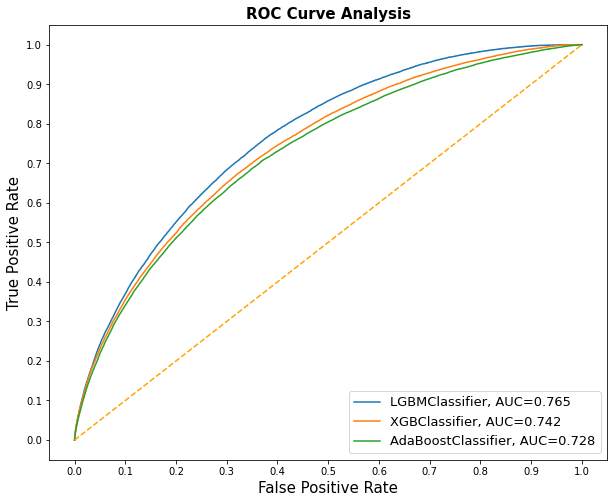

In [55]:
fig = plt.figure(figsize=(10,8))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc'])
             )
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

Hasil Model Terbaik adalah menggunakan Metode LGBMClassifier

### Pemilihan Model Terbaik

In [57]:
lgb.fit(X_train_final, y_train)
y_pred_LGB = lgb.predict(X_train_final)
y_pred_LGB_test = lgb.predict(X_test_final)

In [58]:
output = pd.DataFrame({'SK_ID_CURR': X_test_final.SK_ID_CURR, 
                       'TARGET': lgb.predict_proba(X_test_final)[:,1]})
output.head()

,SK_ID_CURR,TARGET
0,100001,0.487904
1,100005,0.691852
2,100013,0.146813
3,100028,0.243653
4,100038,0.380232


In [60]:
output.to_csv('submission.csv', index=False)